# Analysing Job Postings #

## Introduction ##

In this project, I'll be doing an analysis of ~4,400 data-related job listings obtained via web-scraping from a Singapore job portal. This is one of four assigned projects as part of the Data Science Immersive at General Assembly - you can check the rest out at my [GA github repo](https://github.com/zacharyang/dsi-sg-6).

## Objectives ## 

The [instructions](https://github.com/zacharyang/dsi-sg-6/blob/master/Project-4/README.md) for this project are pretty open ended so I've set a few objectives for myself in this project:

1. Collect a set of job listings and information; process clean it into a useful data set
2. To predict estimated salary levels using features generated from the job listings
3. To understand what factors set apart a data scientist or analyst from a data-related job

<br>
<div style='text-align:center'><img src='./images/took-our-jobs.gif'>*Hopefully it won't come to this*</img></div>

## Notebook Outline ##

1. [Data Collection](#collection)
2. [Data Cleaning and Exploration](#clean)     
2.1 [Feature Engineering](#engineer)     
2.2 [Feature Extraction from text](#extract)
3. [Salary Analysis & Modelling](#salary)     
3.1 [Text-based models to predict salary](#text)      
3.2 [Numerical/Categorical models](#dense)     
3.3 [Stacked model](#stack)
4. [Job Category Analysis](#feature)      
4.1 [What skills are required for a data gig?](#skills)




<h2><a name='collection'> 1. Data Collection </a></h2>

I used web scraping to obtain a total of 4,416 job listings from the website, which were put together using the website's search tool with the search keyword "data". This yielded job listings that were data-related and ranged from jobs such as data analyst to data scientist, business analysts as well as administrative positions. I went through 221 pages of search results to get the links to all the job listings first, and extracted information from each listings to assemble the job listing data.

I extracted several groups of attributes for each job listings: a) Salary Information; b) Employer Information; c) Job Information; d) Job Description; and e) Job Requirements. **Figure 1** shows a schematic of how a typical job listing is laid out and where each attribute can be found.

<br>
<div style='text-align:center'><img src='./images/listing_.png' align='middle'><strong>Figure 1: Key attributes of a job listing</img></div>
<br>     

I used `selenium` to send requests for the listings and used `BeautifulSoup` to parse the resultant HTML page. I ran 5 concurrent web drivers to get a total of 4,416 job listings. Each driver took an average of 5 second per listing and had to get ~800 listings each, so the total data collection process took just under 2 hours. You can replicate the data collection process using two scripts: [`get_job_listings.py`](https://github.com/zacharyang/dsi-sg-6/blob/master/Project-4/get_job_listings.py) gets the links for all job listings returned from a keyword search of 'data' and caches it in the data directory. [`get_jobs.py`](https://github.com/zacharyang/dsi-sg-6/blob/master/Project-4/get_jobs.py) sets up the webdrivers and parses the information out into a csv format, caching it in the data directory as well. 


<h2><a name='clean'>2. Data Cleaning & Exploration </a></h2>

In this section, I'll be loading the data and doing some cleaning. Some of the work has already been done in the parser in `get_jobs.py`, but some further cleaning may be necessary

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import warnings
import re
sns.set_style("whitegrid")

warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Data is in 5 separate csv files from 5 separate web drivers # 
files=['./data/jobs_{}.csv'.format(i) for i in range(1,6)]
df=pd.concat([pd.read_csv(file) for file in files])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4416 entries, 0 to 418
Data columns (total 13 columns):
company_location    3379 non-null object
company_name        4416 non-null object
date_expiry         4416 non-null object
date_posted         4416 non-null object
employment_type     4416 non-null object
job_description     4416 non-null object
job_requirements    4233 non-null object
job_title           4416 non-null object
num_apps            4416 non-null float64
salary_lower        3912 non-null float64
salary_type         3912 non-null object
salary_upper        3912 non-null float64
seniority           4334 non-null object
dtypes: float64(3), object(10)
memory usage: 483.0+ KB


In [4]:
df.sample(5)

,company_location,company_name,date_expiry,date_posted,employment_type,job_description,job_requirements,job_title,num_apps,salary_lower,salary_type,salary_upper,seniority
90,"South Beach Tower, 38 Beach Road 189767",Lego Singapore Pte. Ltd.,15 Feb 2019,16 Jan 2019,Permanent,Roles & ResponsibilitiesOne of the biggest & f...,RequirementsDo you have what it takes? • Minim...,"Senior Regional Marketing Manager, Boys 6-8",35.0,102000.0,Annually,204000.0,Senior Management
593,"One Sims Lane, 1 Sims Lane 387355",Neucor Holdings Pte Ltd,17 Feb 2019,18 Jan 2019,"Permanent, Full Time",Roles & ResponsibilitiesThe Accounts Executive...,Requirements ~ Assign account codes to all tra...,Accounts Executive,20.0,2000.0,Monthly,3200.0,Executive
243,"Southbank, 883 North Bridge Road 198785",Observational And Pragmatic Research Institute...,07 Feb 2019,08 Jan 2019,"Permanent, Full Time",Roles & ResponsibilitiesObservational and Prag...,RequirementsQualifications BSc or equivalent q...,Junior Data Analyst,22.0,3000.0,Monthly,4000.0,Junior Executive
184,"Airline House, 25 Airline Road 819829",Singapore Airlines Limited,21 Feb 2019,22 Jan 2019,Permanent,Roles & ResponsibilitiesYou will be responsibl...,Requirements Degree holder with minimum 10 yea...,Principal Technologist (Threat Management),9.0,7000.0,Monthly,14000.0,Professional
885,"Golden Mile Complex, 5001 Beach Road 199588",Mapq Consulting Pte. Ltd.,16 Feb 2019,17 Jan 2019,"Part Time, Permanent, Full Time, Flexi Work",Roles & Responsibilities To handle partial of ...,Requirements Minimum 2 years of accounting exp...,Account Assistant,16.0,1600.0,Monthly,2200.0,Junior Executive


In [5]:
df.shape

(4416, 13)

For the first part of my analysis, I'll be looking at what factors influence the salary level for a job, so I'll be focusing on job listings with salary information only. Salary information also comes as a range now, so I'll be taking the mid-point of the salary range as a preliminary target variable. The salary information in some job listings comes as annual instead of monthly salary, so I'll be converting salary information to a monthly base. 

In [6]:
# Subset the data to focus on listings with salary information # 
salary=df[df['salary_upper'].notna()]
salary.reset_index(drop=True,inplace=True)
# Set target variable as mid point of salary range # 
salary['salary_']=(salary.salary_upper + salary.salary_lower)/2

In [7]:
salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3912 entries, 0 to 3911
Data columns (total 14 columns):
company_location    3046 non-null object
company_name        3912 non-null object
date_expiry         3912 non-null object
date_posted         3912 non-null object
employment_type     3912 non-null object
job_description     3912 non-null object
job_requirements    3828 non-null object
job_title           3912 non-null object
num_apps            3912 non-null float64
salary_lower        3912 non-null float64
salary_type         3912 non-null object
salary_upper        3912 non-null float64
seniority           3900 non-null object
salary_             3912 non-null float64
dtypes: float64(4), object(10)
memory usage: 428.0+ KB


In [8]:
salary['salary_type'].value_counts()

Monthly     3797
Annually     115
Name: salary_type, dtype: int64

In [9]:
# Some salary information still in annual format, so convert all to monthly # 
salary['salary']=salary.apply(lambda x: x['salary_']/12 if x['salary_type']=='Annually' else x['salary_'],axis=1)

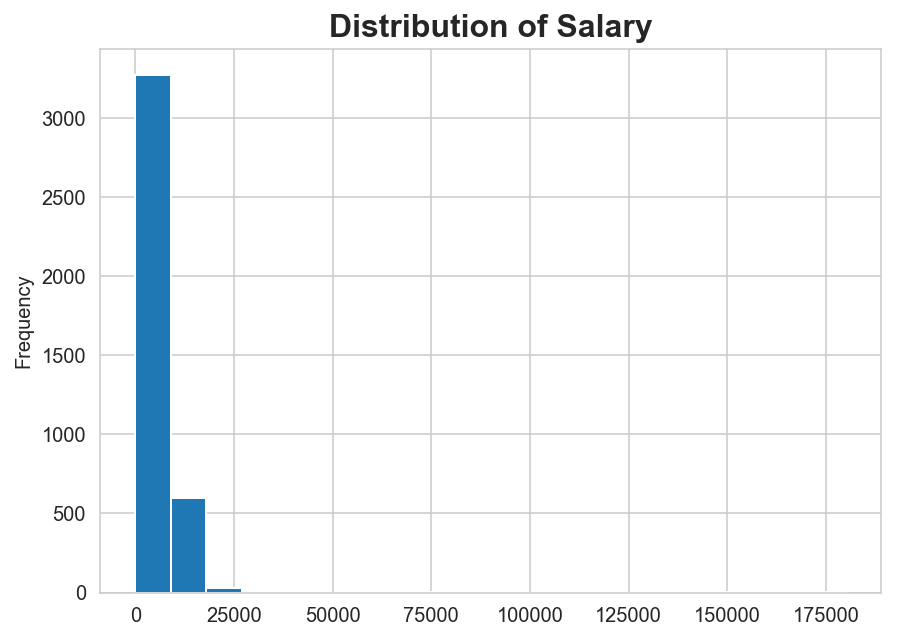

In [10]:
# Distribution is highly skewed
plt.figure(figsize=(7,5))
salary['salary'].plot.hist(bins=20)
plt.title('Distribution of Salary',fontsize=16,fontweight='bold')
plt.show()

In [11]:
# Checking outliers # 

salary[salary['salary']>30000]

,company_location,company_name,date_expiry,date_posted,employment_type,job_description,job_requirements,job_title,num_apps,salary_lower,salary_type,salary_upper,seniority,salary_,salary
16,137 Telok Ayer Street 068602,Inc Research Cro Singapore Pte. Ltd.,28 Feb 2019,29 Jan 2019,"Permanent, Full Time",Roles & ResponsibilitiesThe Senior Clinical Re...,RequirementsRequirements: BA/BS degree in scie...,Sr Clinical Research Associate,0.0,80000.0,Monthly,90000.0,"Professional, Executive, Senior Executive",85000.0,85000.0
23,137 Telok Ayer Street 068602,Inc Research Cro Singapore Pte. Ltd.,28 Feb 2019,29 Jan 2019,"Permanent, Full Time",Roles & ResponsibilitiesPerforms assigned acti...,RequirementsRequirements: BA/BS degree in th...,Sr Site Start-Up & Regulatory Specialist,1.0,70000.0,Monthly,80000.0,"Professional, Senior Executive",75000.0,75000.0
693,"Woodlands Spectrum, 2 Woodlands Sector 1 738068",Ultra Clean Asia Pacific Pte. Ltd.,23 Feb 2019,24 Jan 2019,"Permanent, Full Time",Roles & Responsibilities Designing and impleme...,RequirementsPivotal Experience & Expertise Op...,Chief Operationg Officer,48.0,40000.0,Monthly,80000.0,Senior Management,60000.0,60000.0
994,NaN,Ihs Markit Asia Pte. Ltd.,21 Feb 2019,22 Jan 2019,"Permanent, Full Time",Roles & ResponsibilitiesDepartment overview: I...,RequirementsEducation and experience Underg...,"Senior Associate, Research And Analysis (Korea...",11.0,50000.0,Monthly,80000.0,Senior Executive,65000.0,65000.0
1054,"Ncs Hub, 5 Ang Mo Kio Street 62 569141",Ncs Pte. Ltd.,21 Feb 2019,22 Jan 2019,Permanent,Roles & ResponsibilitiesPosition Summary Setu...,Requirements Minimum 3 years of experience in ...,Lead / Senior Database Administrator,2.0,5000.0,Monthly,85000.0,Professional,45000.0,45000.0
1384,"Suntec Tower Two, 9 Temasek Boulevard 038989",Six Financial Information Singapore Pte. Ltd.,17 Feb 2019,18 Jan 2019,Full Time,Roles & ResponsibilitiesThe new position is av...,RequirementsCandidates should have a backgroud...,Senior Sales Manager,4.0,120000.0,Monthly,170000.0,Middle Management,145000.0,145000.0
1397,NaN,Company Undisclosed,17 Feb 2019,18 Jan 2019,Full Time,Roles & Responsibilities COMPANY DESCRIPTION ...,RequirementsRequired Skills: BS/MS in Compute...,Research Engineer,1.0,60000.0,Monthly,80000.0,Fresh/Entry Level,70000.0,70000.0
1432,"Suntec Tower Two, 9 Temasek Boulevard 038989",Six Financial Information Singapore Pte. Ltd.,17 Feb 2019,18 Jan 2019,Full Time,Roles & ResponsibilitiesThe SSO group provides...,RequirementsMain Duties 1. A key positive aspe...,Head Of Sso (Apac),5.0,144000.0,Monthly,216000.0,Middle Management,180000.0,180000.0
2754,"Sgx Centre I, 2 Shenton Way 068804",Dtcc Data Repository (Singapore) Pte. Ltd.,07 Feb 2019,09 Jan 2019,Full Time,Roles & ResponsibilitiesBusiness Unit Descript...,RequirementsQualifications Minimum of 8 years...,Senior Business Systems Analyst,11.0,50000.0,Monthly,75000.0,Senior Executive,62500.0,62500.0
2931,"Suntec Tower Two, 9 Temasek Boulevard 038989",Six Financial Information Singapore Pte. Ltd.,07 Feb 2019,08 Jan 2019,Full Time,Roles & ResponsibilitiesThe new position is av...,RequirementsCandidates should have a backgroud...,Senior Sales Manager,4.0,120000.0,Monthly,170000.0,Middle Management,145000.0,145000.0


Here, I found 13 observations that are likely to be outliers given the implausibility of the salary range and the associated job titles. I'll be dropping them from my analysis. 

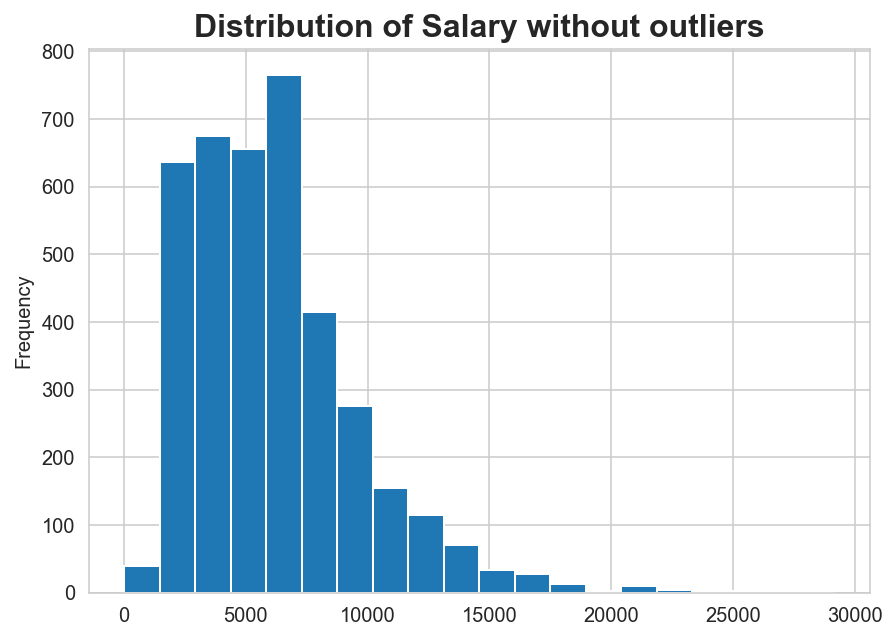

In [12]:
salary=salary[salary['salary']<30000]
salary.reset_index(drop=True,inplace=True)

plt.figure(figsize=(7,5))
salary['salary'].plot.hist(bins=20)
plt.title('Distribution of Salary without outliers',fontsize=16,fontweight='bold')
plt.show()

<h2><a name='engineer'> 2.1 Feature Engineering </a></h2>

I'll be generating several more features from the columns on seniority, employment type and the date features. 

For the seniority and employment types, multiple categories may be listed in one description so a simple one hot encoding would not work. 

In [13]:
salary['seniority'].sample(10)

379                Senior Executive
2784                   Professional
2727                      Executive
2564    Executive, Senior Executive
2793              Middle Management
1959                      Executive
2509                      Executive
2620                        Manager
1041          Manager, Professional
2952                      Executive
Name: seniority, dtype: object

In [14]:
# Generating dummies for seniority and employment type # 

salary['seniority'].fillna('',inplace=True)
seniority_cat=salary['seniority'].str.get_dummies(sep=', ')
salary['employment_type'].fillna('',inplace=True)
etype_cat=salary['employment_type'].str.get_dummies(sep=', ')

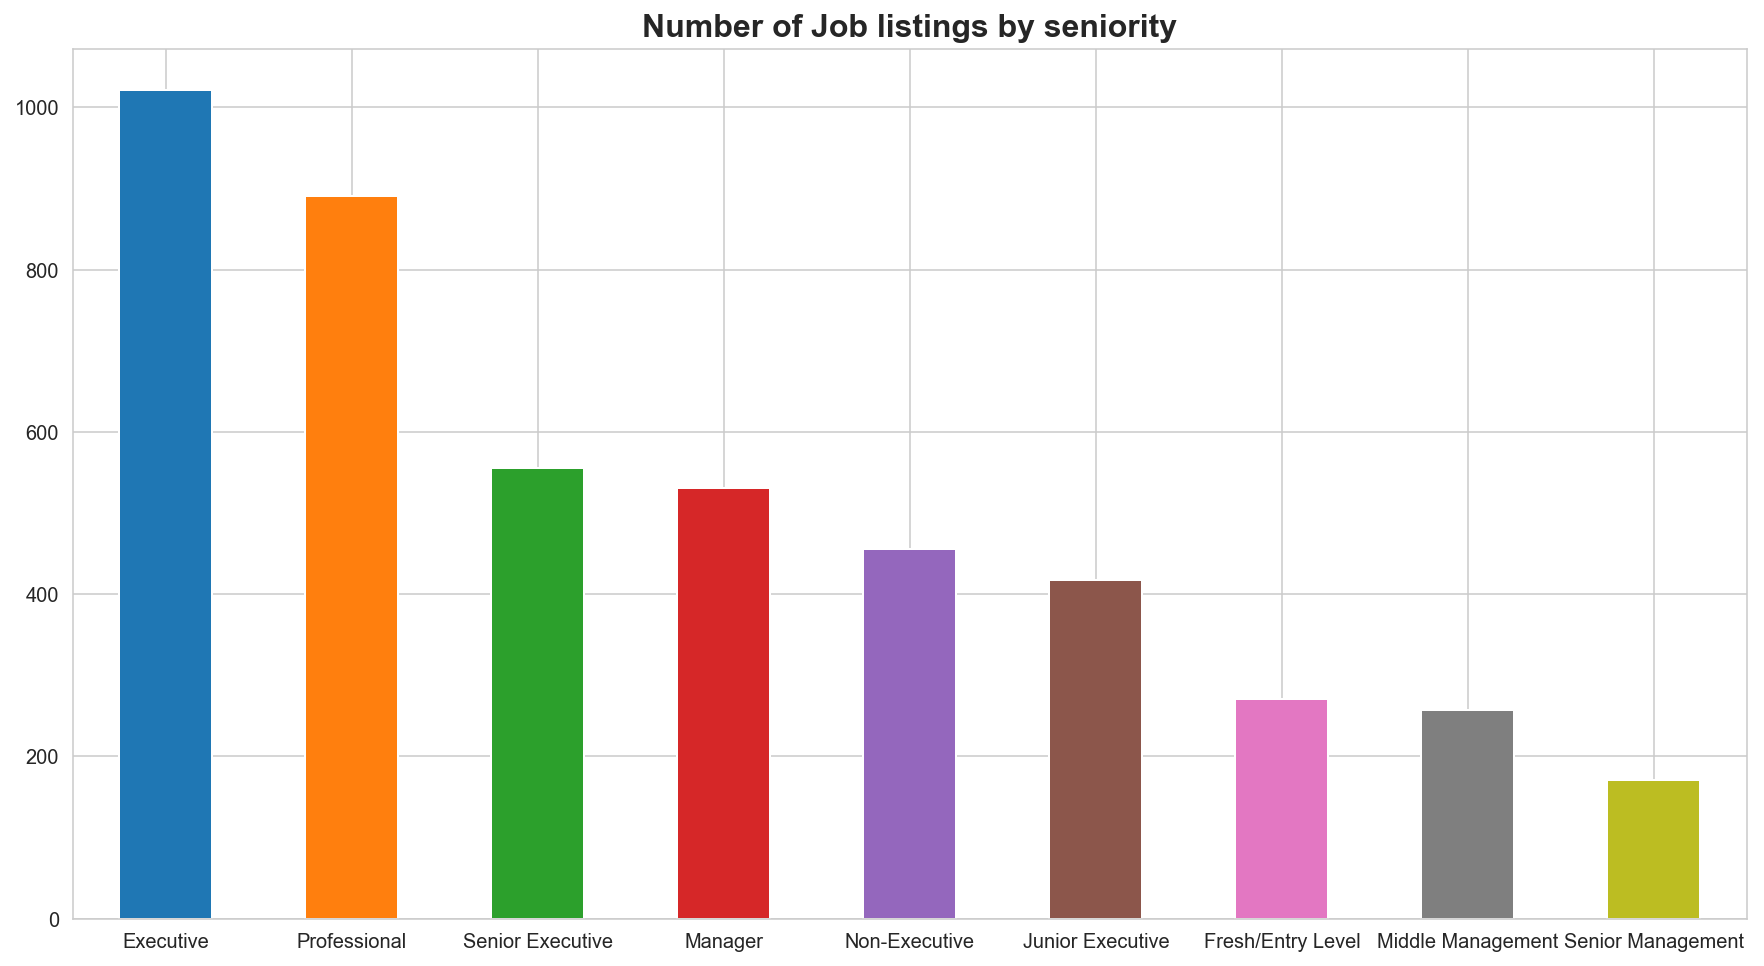

In [15]:
plt.figure(figsize=(15,8))
ax=seniority_cat.apply(sum).sort_values(ascending=False).plot.bar()
labels=ax.get_xticklabels()
ax.set_xticklabels(labels,rotation=0)
ax.set_title('Number of Job listings by seniority',fontsize=16,fontweight='bold')
plt.show()

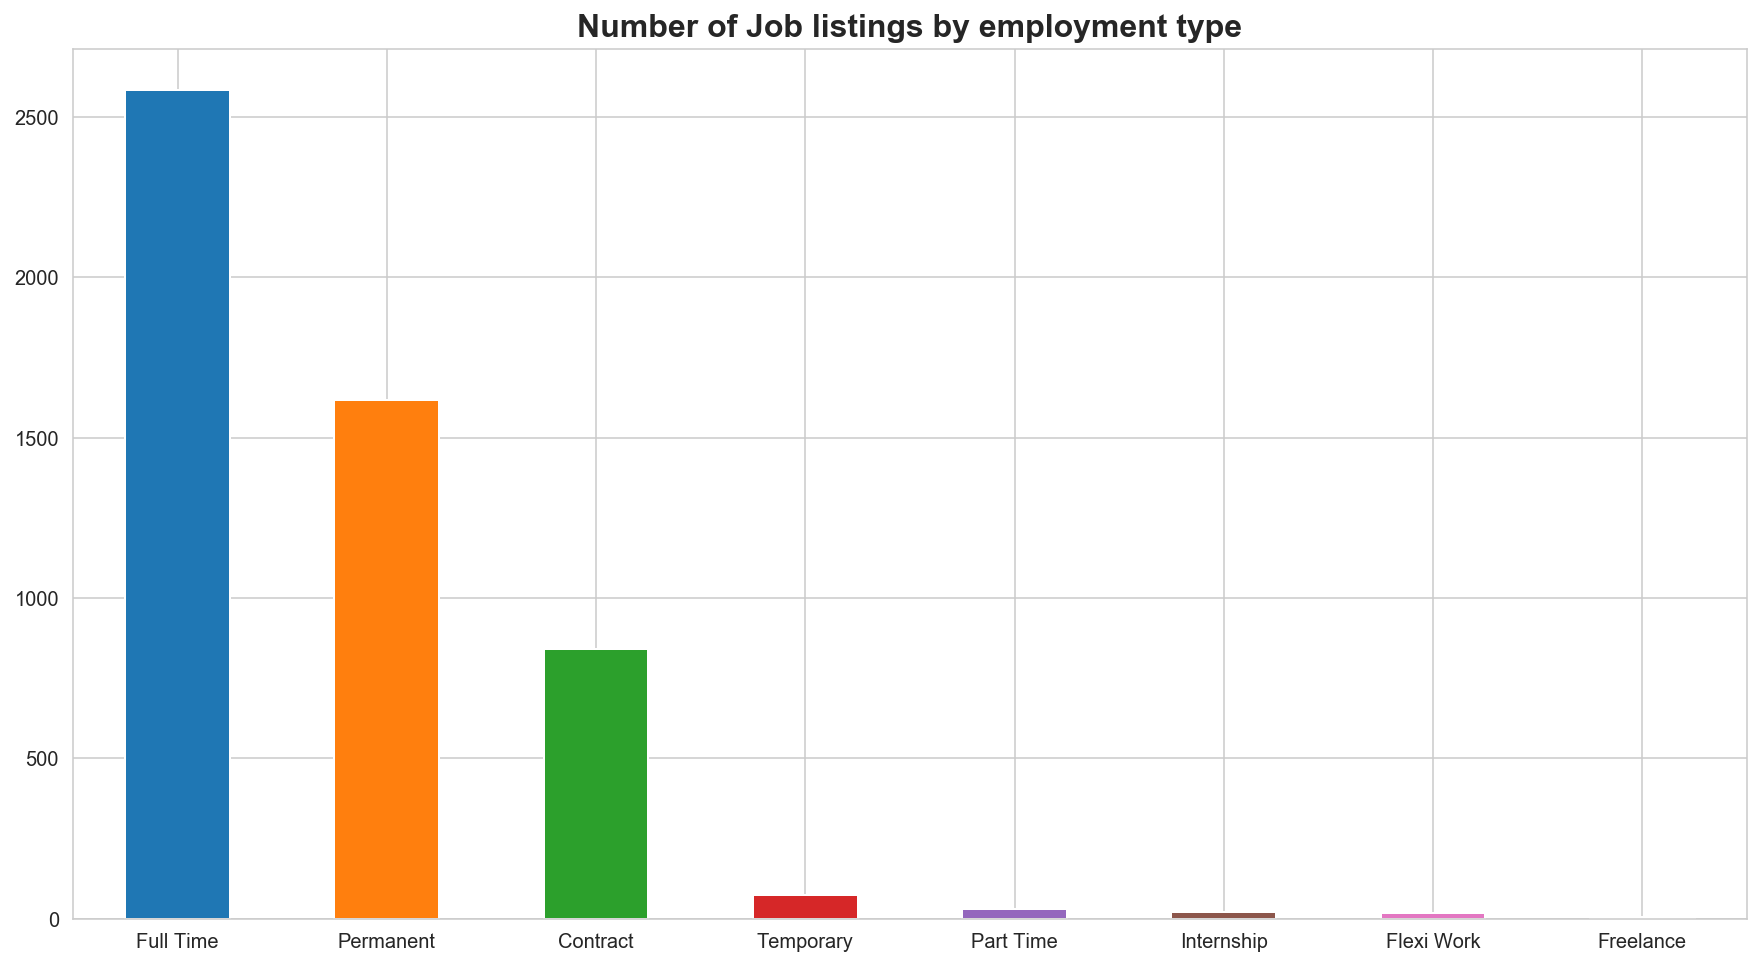

In [16]:
plt.figure(figsize=(15,8))
ax=etype_cat.apply(sum).sort_values(ascending=False).plot.bar()
labels=ax.get_xticklabels()
ax.set_xticklabels(labels,rotation=0)
ax.set_title('Number of Job listings by employment type',fontsize=16,fontweight='bold')
plt.show()

In [17]:
salary=pd.concat([salary,seniority_cat,etype_cat],axis=1)


In [18]:
# Converting to date time and generating new feature, number of days to apply # 

salary['date_expiry']=salary['date_expiry'].apply(lambda x: datetime.datetime.strptime(x,"%d %b %Y"))
salary['date_posted']=salary['date_posted'].apply(lambda x: datetime.datetime.strptime(x,"%d %b %Y"))
salary['num_day_apply']=salary['date_expiry']-salary['date_posted']
salary['num_day_apply']=salary['num_day_apply'].apply(lambda x: x.days)

<h2><a name='extract'>2.2 Feature Extraction from text</a></h2>

There are two main chunks of text in the data, one which gives the job description ie. what the job entails; and the job requirements, which describes the skills required for the job. I'll be extracting the features using a simple Bag-of-Words approach, and TF-IDF. 

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words

In [20]:
## Generate text features  ## 

# Remove the words that mark the start of every section of JD and JR # 
salary['job_description']=salary['job_description'].apply(lambda x : re.sub(r'roles & responsibilities', '', x.lower()) if x is not np.nan else '')
salary['job_requirements']=salary['job_requirements'].apply(lambda x : re.sub(r'requirements.*?(?=\s)', '', x.lower()) if x is not np.nan else '')

# Setting up stopword list # 
stopwords = list(stop_words.ENGLISH_STOP_WORDS)
stopwords+= ['requirements','minimum','qualifications','enhance','email']

cvec1=CountVectorizer(stop_words=stopwords,max_features=1000,ngram_range=(1,2),min_df=2)
cvec2=TfidfVectorizer(stop_words=stopwords,max_features=1000,min_df=2)
X1=cvec1.fit_transform(salary['job_requirements'])
X2=cvec2.fit_transform(salary['job_requirements'])

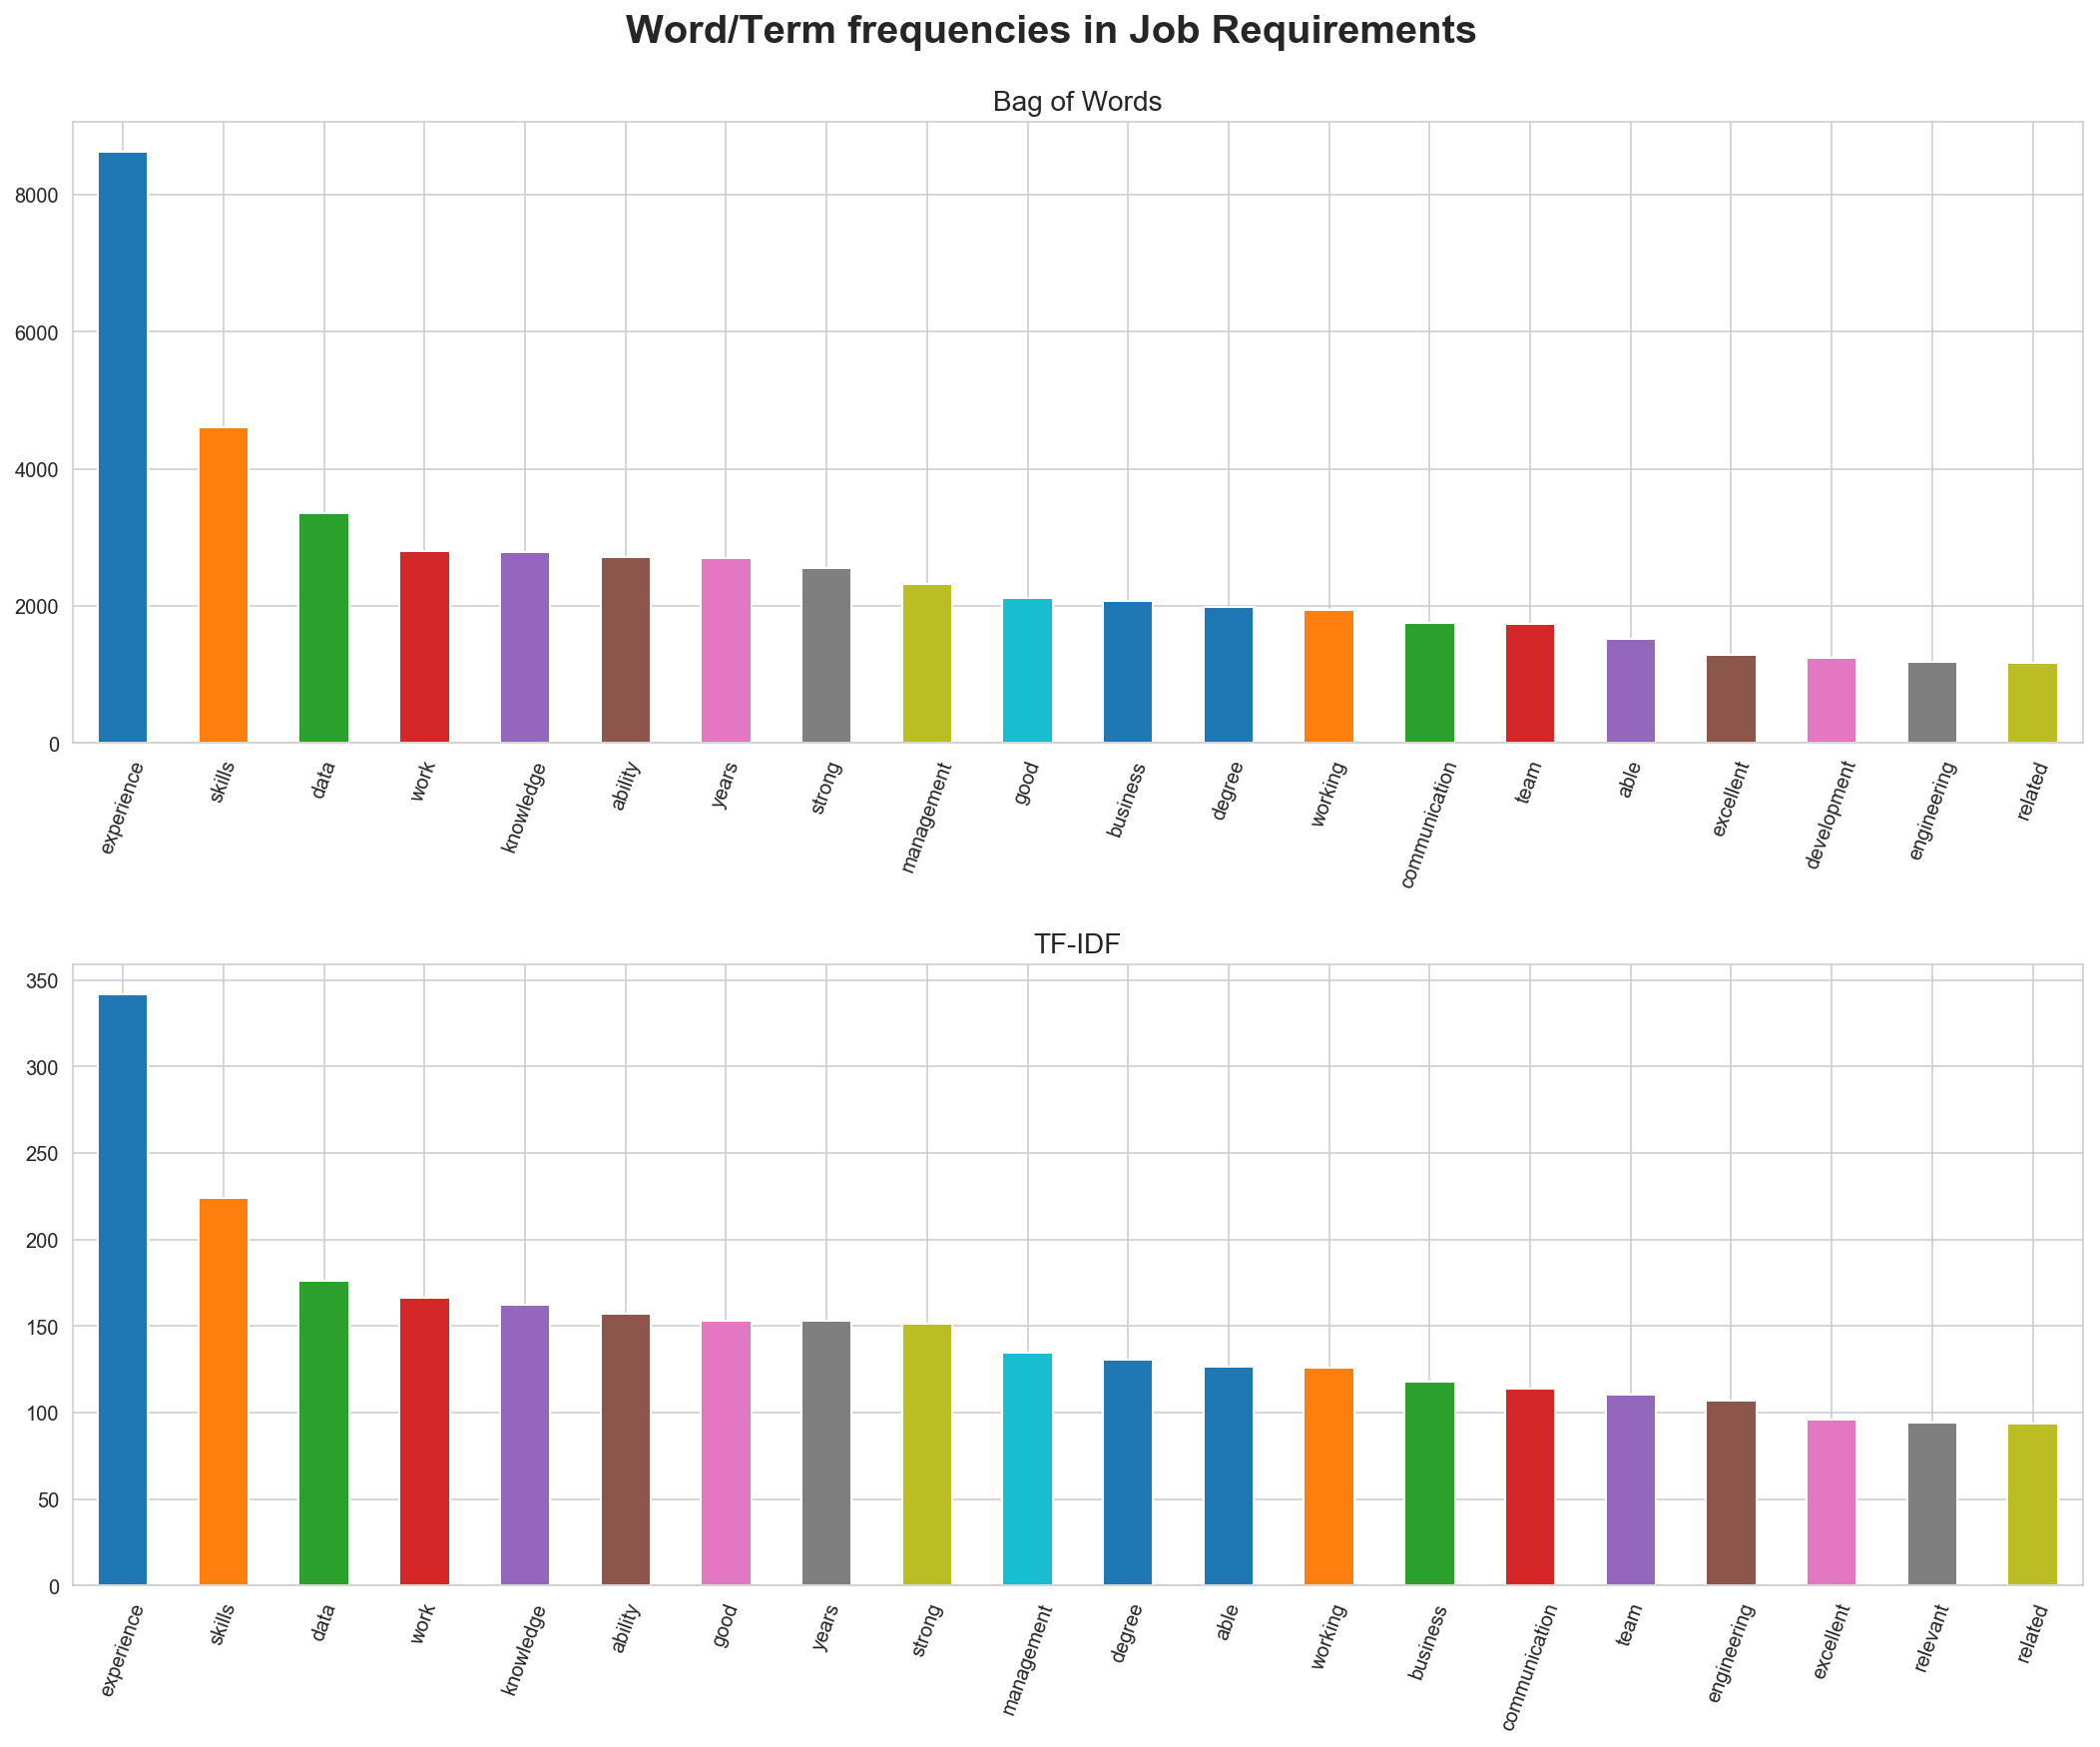

In [21]:
f,ax=plt.subplots(2,1,figsize=(15,12))

pd.DataFrame(X1.todense(),columns=cvec1.get_feature_names()).apply(sum).sort_values(ascending=False).head(20).plot.bar(ax=ax[0])

label1=ax[0].get_xticklabels()
ax[0].set_xticklabels(label1,rotation=70)
ax[0].set_title('Bag of Words', fontsize=14)
pd.DataFrame(X2.todense(),columns=cvec2.get_feature_names()).apply(sum).sort_values(ascending=False).head(20).plot.bar(ax=ax[1])
label2=ax[1].get_xticklabels()
ax[1].set_xticklabels(label2,rotation=70)
ax[1].set_title('TF-IDF', fontsize=14)
f.suptitle('Word/Term frequencies in Job Requirements',y=1.02, fontsize=20, fontweight='bold')
plt.tight_layout(pad=2)
plt.show()


Both methods of extracting text features look fairly comparable. While TF-IDF prioritises less frequently appearing words, top 5 by ranking are similar for both methods of feature extraction. The corpus looks fairly diverse looking at the top 20 terms, so I probably won't need to stem/lemmatize these words. 

<h2><a name='salary'> 3. Salary Analysis & Modelling </a></h2>

Given the data set and features, the first question I'd like to answer is **what features of a job listing help to predict whether a job will yield a high salary**. 

I'll be setting up the problem as a binary classification problem, with a "high salary" level defined as a monthly salary above the 70th percentile of the salary distribution, or jobs with monthly salary above 7,000 dollars.

I'll be stacking 3 models built from three components of the dataset. The first model will be a text-based model built on the job description section as features, the second will be a text based model on the job requirements as features, while the the third model will use the numerical and categorical features from the dataset.

The second level model will be built upon the meta features generated from the first level models. A schematic for this modelling flow is shown in **Figure 2**.


<br>
<div style='text-align:center'><img src='./images/stacking.png' align='middle'><strong>Figure 2: Stacked Model to predict salary level</img></div>
<br>     

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import  BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



In [23]:
# Define target as binary variable. Salaries above 70th considered high #  
y=(salary['salary']>salary['salary'].quantile(0.70)).astype(int)
print('Salaries above ${} per month will be considered "high"'.format(salary['salary'].quantile(0.70)))

Salaries above $7000.0 per month will be considered "high"


In [24]:
# Scale numerical features # 

salary['num_day_apply_scaled']=StandardScaler().fit_transform(salary['num_day_apply'].values.reshape(-1,1))
salary['num_apps_scaled']=StandardScaler().fit_transform(salary['num_apps'].values.reshape(-1,1))

In [25]:
# Split into train and test set # 
sss=StratifiedShuffleSplit(n_splits=2,test_size=0.2,random_state=120)

for train_index, test_index in sss.split(salary, y):
    salary_train,salary_test= salary.iloc[train_index], salary.iloc[test_index]
    y_train,y_test= y.iloc[train_index].values, y.iloc[test_index].values
    

<h2><a name='text'>3.1 Base Models 1 & 2: Text-based model to predict salary</a></h2>

Given the variety of ways to change the model pipeline, I will follow the following procedures to choose the best performing text-based model. 

**Step 1:** Define the range of text feature extraction methods and predictive models     
- I'll consider a Bag-of-Words and TF-IDF vectoriser here.
- For models, I'll try a Linear Support Vector Classifier, Logistic Regression and Naive Bayes.
<br>       

**Step 2:** Set up predictor matrix for each feature extraction method      
<br>

**Step 3**: Perform 5-fold cross validation for each feature extraction method and model  
- Yielding a total of 6 unique models for each feature set.
- Using AUC-ROC as a model selection metric.

Given the varying pre-processing steps and models, I'll be using a `sklearn`'s `Pipeline` to help build the estimator. 

In [26]:
# Utility function for model selection # 

def cross_val_class(model,name,X,y,scoring=None,folds=5,verbose=True):

    '''Takes a fitted model, name, feature set and target variable and prints the cross validated score and 
    returns the mean score for the cross-validation procedure'''

    scores = cross_val_score(model, X, y, cv=folds,scoring=scoring)

    print( '------------------------------------\n')
    print('{}-Fold Cross Validated Results for Model: '.format(folds)+ name)

    if scoring==None:
        print('Performance Metric: Accuracy')
    else:
        print('Performance Metric: '+scoring)

    print("Cross-validated scores:", scores)
    print("Mean score:", np.mean(scores))
    print('Std score:', np.std(scores))

    return np.mean(scores)


# Define a class object to help with the model selection # 
class BestNLP:
    
    def __init__(self,stop_words,max_features,ngram_range, min_df):
        self.stop_words=stop_words
        self.min_df=min_df
        self.max_features=max_features
        self.ngram_range=ngram_range
        
    
    def init_vectorizers(self):
        ''' Initialise two vectorizers , BOW and TF-IDF. Returns a tuple that can be passed into Pipeline'''
        cvect=CountVectorizer(stop_words=self.stop_words,max_features=self.max_features,ngram_range=self.ngram_range,min_df=2)
        tfidf=TfidfVectorizer(stop_words=self.stop_words,min_df=self.min_df,max_features=self.max_features)
        return [('BOW',cvect),('TF-IDF',tfidf)]

        
    def fitCV(self,models,X,y,scoring=None,n_folds=5):
        
        '''Cross validates across different feature extraction methods and predictive models, 
        printing the cross validated score'''
        
        # Initialise a vector of scores, estimators, vectorisers and feature matrix 
        # helps to locate the best performing estimator 
        scores=[]
        estimators=[]
        names=[]
        vectorizers_=[]
        sparse_Xs=[]
        
        for model in models:
            # Initialise new vectorizers for each predictive model 
            vectorizers = self.init_vectorizers()
            
            for vectorizer in vectorizers:

                X_vec=vectorizer[1].fit_transform(X)
                estimator=Pipeline([vectorizer,model])
                estimator.fit(X,y)
                name=vectorizer[0]+'-'+model[0]
                # Print cross val results # 
                mean_score=cross_val_class(estimator,name,X,y,scoring,folds=n_folds)
                
                # Store all info in a list for easy indexing# 
                vectorizers_.append(vectorizer)
                scores.append(mean_score)
                estimators.append(estimator)
                names.append(name)
                sparse_Xs.append(X_vec)
        
        # Look up index where the score is the best # 
        best_ind=scores.index(max(scores))
        # Store it in the class object # 
        self.vect=vectorizers_[best_ind]
        self.best_estimator=estimators[best_ind]
        self.X_=sparse_Xs[best_ind]
        self.estimator_CVscores=dict(zip(names,scores))
    

In [48]:
# Set up the 3 models, NB, Log Regression, Linear SVC # 
nb= BernoulliNB()
lr=LogisticRegression(max_iter=500,solver='lbfgs')
svc=LinearSVC(max_iter=3000)
models=[('Naive-Bayes',nb),('Logistic Regression',lr),('Linear SVC',svc)]

In [49]:
NLP_JD=BestNLP(stop_words=stopwords,max_features=1000,ngram_range=(1,2),min_df=2)
NLP_JD.fitCV(models,salary_train['job_description'],y_train,scoring='roc_auc')

------------------------------------

5-Fold Cross Validated Results for Model: BOW-Naive-Bayes
Performance Metric: roc_auc
Cross-validated scores: [0.7817548  0.78489714 0.77761821 0.80421761 0.79274009]
Mean score: 0.7882455679696336
Std score: 0.009397761899232172
------------------------------------

5-Fold Cross Validated Results for Model: TF-IDF-Naive-Bayes
Performance Metric: roc_auc
Cross-validated scores: [0.7817548  0.78344872 0.7741199  0.80111823 0.79298   ]
Mean score: 0.7866843282741106
Std score: 0.009387302725315884
------------------------------------

5-Fold Cross Validated Results for Model: BOW-Logistic Regression
Performance Metric: roc_auc
Cross-validated scores: [0.7743654  0.82009501 0.80813325 0.80122257 0.77797667]
Mean score: 0.7963585792245477
Std score: 0.017591554427923185
------------------------------------

5-Fold Cross Validated Results for Model: TF-IDF-Logistic Regression
Performance Metric: roc_auc
Cross-validated scores: [0.83759267 0.86725463 0.8

The best performing estimator is the TF-IDF Logistic Regression combination, so I'll use that as the level 1 model for Job Description. Further, it may be instructive to look at the coefficients for logistic regression to see which features/words contribute to the odds of getting a higher paying job

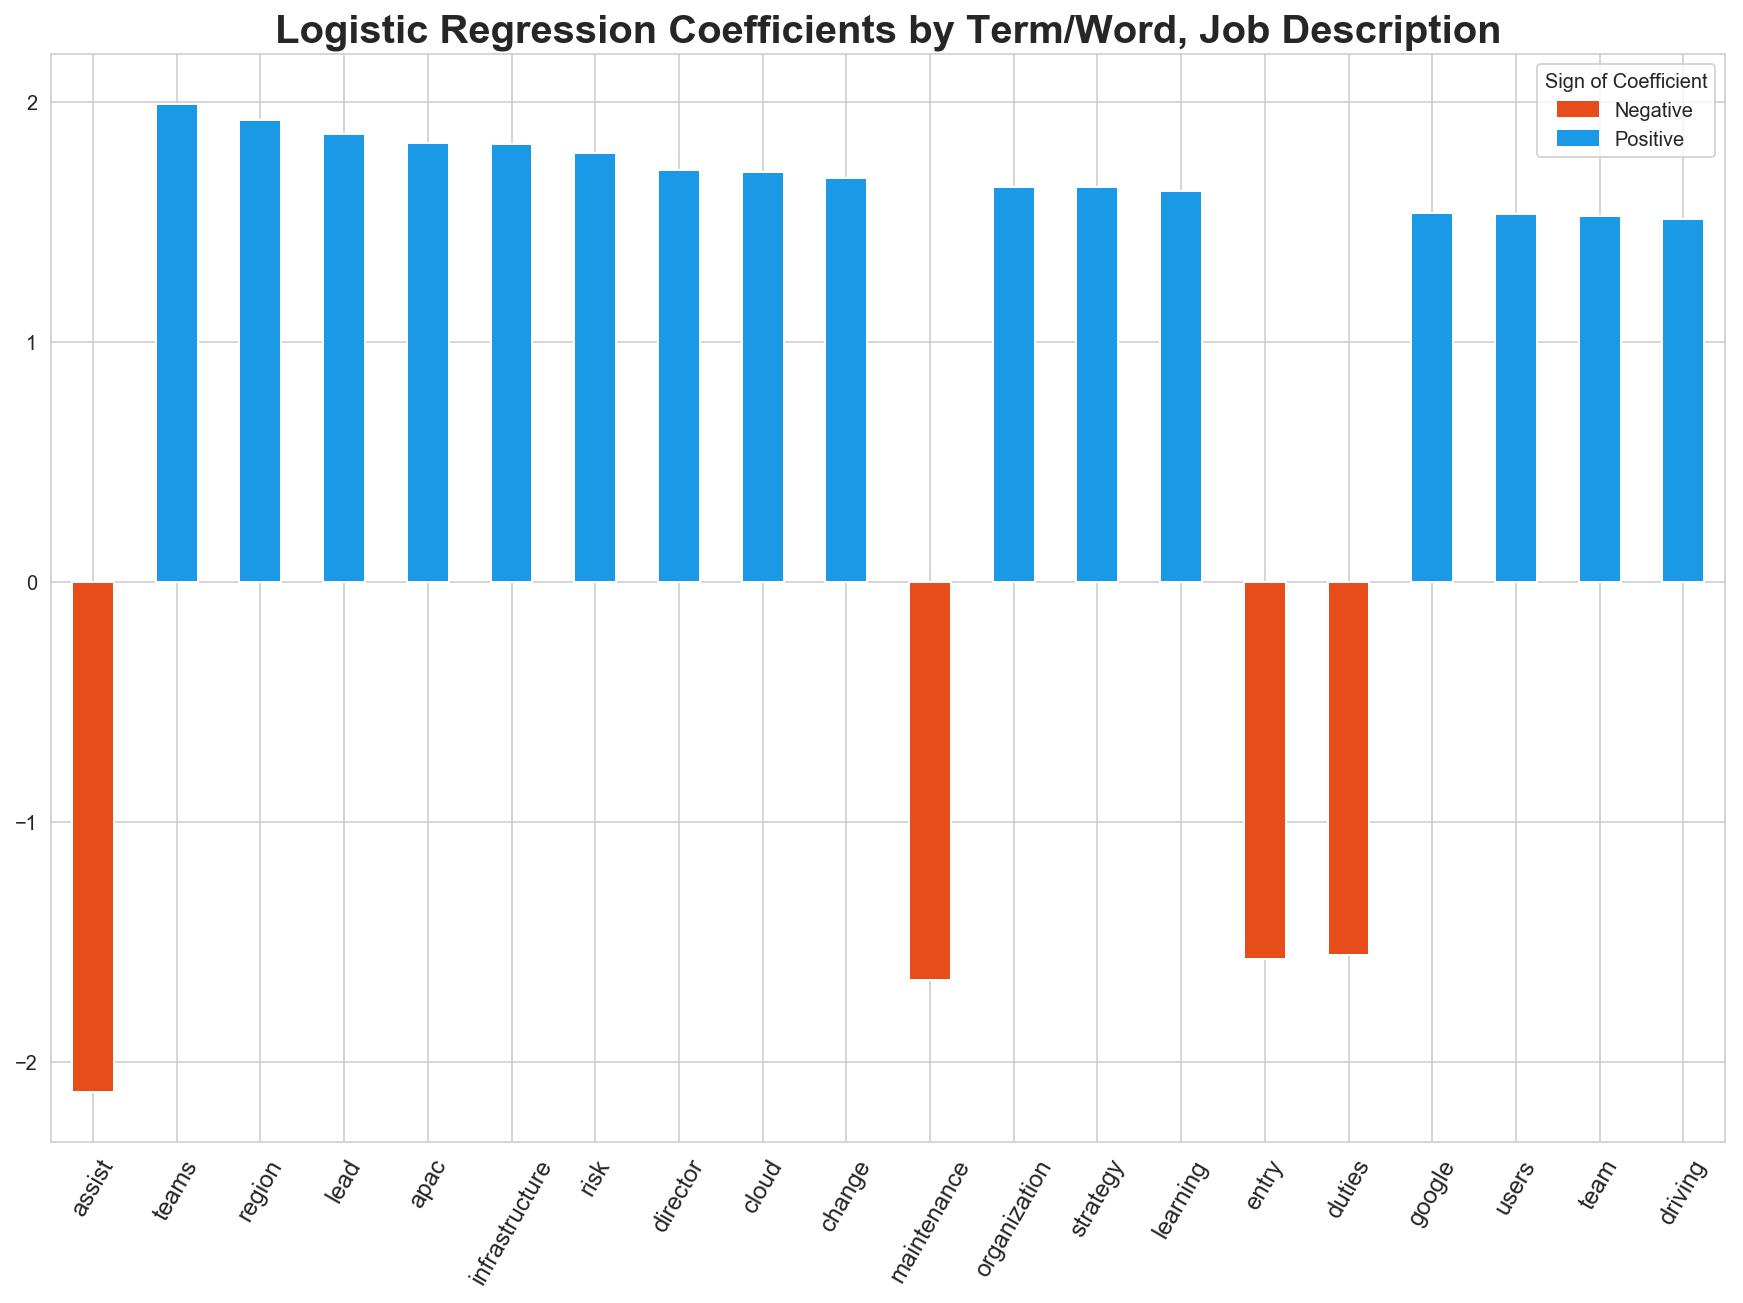

In [469]:
# Set up coefficient dataframe # 
coef= NLP_JD.best_estimator.named_steps['Logistic Regression'].coef_[0]
feat_names=NLP_JD.vect[1].get_feature_names()

lr_coefs=pd.DataFrame({'coefficient':coef, 'feature_names':feat_names,'abs_coef':np.abs(coef)})
lr_coefs.sort_values('abs_coef',inplace=True,ascending=False)

# Plot top 20 coefficients ranked by abs value # 
to_plot=lr_coefs.head(20)

to_plot['color']=to_plot['coefficient'].apply(lambda x : (0.1,0.6,0.9) if x>0 else (0.9,0.3,0.1))


f=to_plot['coefficient'].plot.bar(color=to_plot['color'],figsize=(15,10))
f.set_xticklabels(to_plot['feature_names'],rotation=60,fontsize=12)
red_patch = mpatches.Patch(color=(0.9,0.3,0.1), label='Negative')
blue_patch= mpatches.Patch(color=(0.1,0.6,0.9), label='Positive')
f.legend(handles=[red_patch,blue_patch],title='Sign of Coefficient')
plt.title('Logistic Regression Coefficients by Term/Word, Job Description', fontsize=20,fontweight='bold')
plt.show()


### Observations 

**1. Leadership is valued highly **
- In Job Descriptions, terms such as "teams", "lead" and "director" all have a highly positive logistic regression coefficient ie. the presence of these terms in the JD means it's more likely the job carries a higher salary level.
- This demonstrates the premium that organisations place on leadership and the responsibilities, which is reflected in salary levels. 

**2. Don't be a cog in the machinery**
- Terms such as "assist" and "maintenance" have highly negative logistic regression coefficients, which imply the presence of these terms in the JD are associated with a lower odds of getting a higher salary level. 
- Organisations are less likely to pay more for workers who come into a role to play an assisting rather than a leading role.

**3. Regional experience matters ** 
- Words such as "region' and 'apac' have highly positive coefficients, reflecting the demand that businesses and organisations place on regional experience in Singapore.


In [30]:
NLP_JR=BestNLP(stop_words=stopwords,max_features=1000,ngram_range=(1,2),min_df=2)
NLP_JR.fitCV(models,salary_train['job_requirements'],y_train,scoring='roc_auc')

------------------------------------

5-Fold Cross Validated Results for Model: BOW-Naive-Bayes
Performance Metric: roc_auc
Cross-validated scores: [0.76558281 0.82472873 0.80722492 0.81803285 0.78481706]
Mean score: 0.8000772719903276
Std score: 0.021926824931214034
------------------------------------

5-Fold Cross Validated Results for Model: TF-IDF-Naive-Bayes
Performance Metric: roc_auc
Cross-validated scores: [0.75306869 0.82205283 0.80547577 0.81732091 0.77595286]
Mean score: 0.7947742113004401
Std score: 0.02630815112632317
------------------------------------

5-Fold Cross Validated Results for Model: BOW-Logistic Regression
Performance Metric: roc_auc
Cross-validated scores: [0.77119851 0.822507   0.82673565 0.81522193 0.77023818]
Mean score: 0.8011802531105697
Std score: 0.025145153549574514
------------------------------------

5-Fold Cross Validated Results for Model: TF-IDF-Logistic Regression
Performance Metric: roc_auc
Cross-validated scores: [0.82404134 0.87564442 0.86

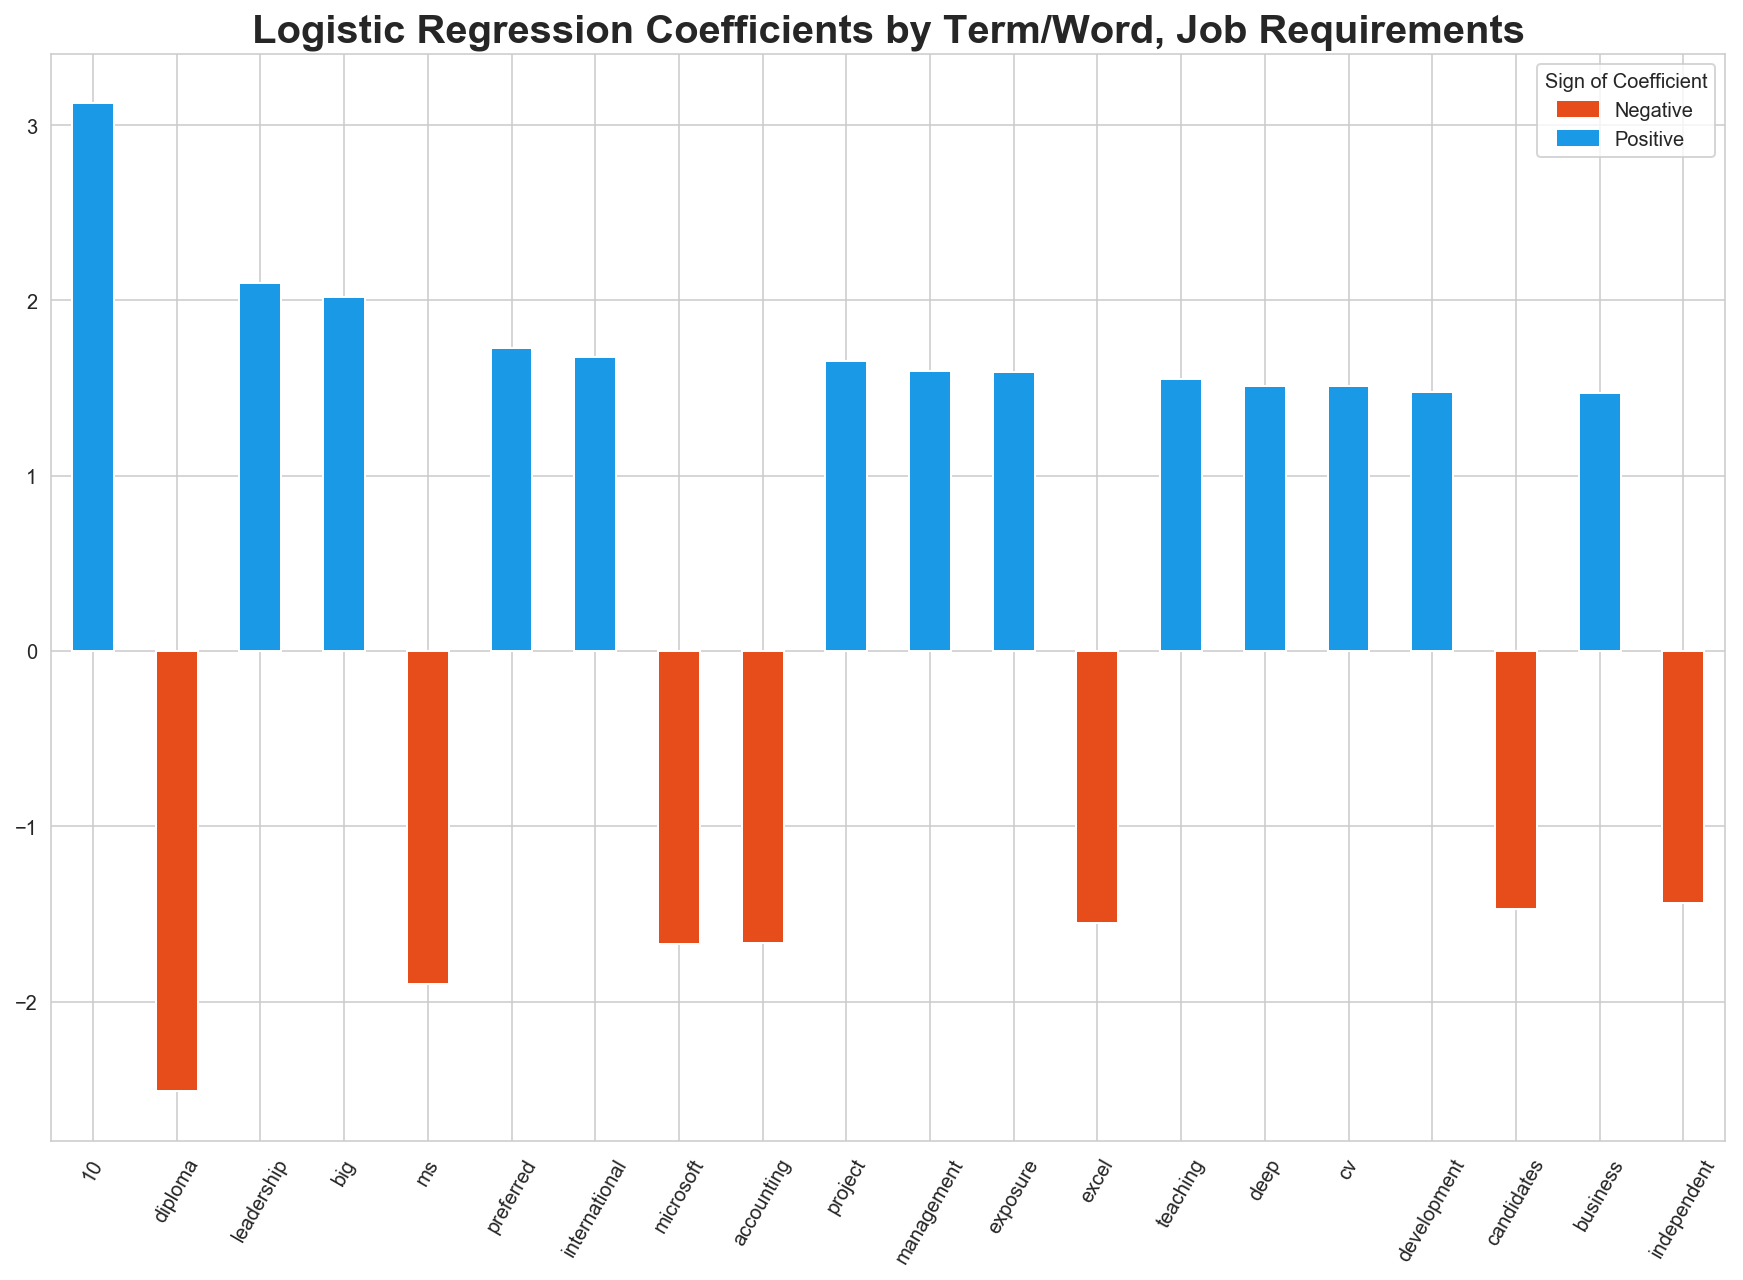

In [467]:
coef= NLP_JR.best_estimator.named_steps['Logistic Regression'].coef_[0]
feat_names=NLP_JR.vect[1].get_feature_names()

lr_coefs=pd.DataFrame({'coefficient':coef, 'feature_names':feat_names,'abs_coef':np.abs(coef)})
lr_coefs.sort_values('abs_coef',inplace=True,ascending=False)
to_plot=lr_coefs.head(20)

to_plot['color']=to_plot['coefficient'].apply(lambda x : (0.1,0.6,0.9) if x>0 else (0.9,0.3,0.1))


f=to_plot['coefficient'].plot.bar(color=to_plot['color'],figsize=(15,10))
f.set_xticklabels(to_plot['feature_names'],rotation=60)
red_patch = mpatches.Patch(color=(0.9,0.3,0.1), label='Negative')
blue_patch= mpatches.Patch(color=(0.1,0.6,0.9), label='Positive')
f.legend(handles=[red_patch,blue_patch],title='Sign of Coefficient')
plt.title('Logistic Regression Coefficients by Term/Word, Job Requirements', fontsize=20,fontweight='bold')
plt.show()

### Observations

**1. Upgrade your skills**
- Terms such as 'diploma', 'microsoft' and 'excel' are all negatively associated with salary levels, indicating a preference for better and more advanced skills
- A diploma based education is still considered by most employers to be insufficient to command a higher salary level, despite emphasis on technical skills. 
- If a company lists 'Microsoft Excel' as part of their required skills, you can expect that it won't be paying a premium for it.




<h2><a name='dense'>3.2 Base Model 3: Using numerical + categorical features to predict salary </a></h2>

Next, I'll be building the last base model using the "denser" features available from the job listings data. Here, I'll be considering three candidate models - Random Forest, Support Vector Classifier and XGBoost. 

For each, I'll be doing a grid search to tune the model hyper-parameters to achieve the best fit for each model. I'll then select the best performing model from the three candidates to be the third level 1 model.

In [32]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier

In [33]:
## Setting up the feature set for Model 3 # 
job_cat=salary[['Executive', 'Fresh/Entry Level',
       'Junior Executive', 'Manager', 'Middle Management', 'Non-Executive',
       'Professional', 'Senior Executive', 'Senior Management', 'Contract',
       'Flexi Work', 'Freelance', 'Full Time', 'Internship', 'Part Time',
       'Permanent', 'Temporary']]


### Dense features model ### 

dense_feats=job_cat.columns.tolist() + ['num_day_apply_scaled','num_apps_scaled']
Xd_train=salary_train[dense_feats]
Xd_test=salary_test[dense_feats]

In [35]:
# Model 1 , Random Forest # 
rf_clf=RandomForestClassifier()

rfr_params={
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [50,100,150,200]}

gs_rf=GridSearchCV(rf_clf,rfr_params,scoring='roc_auc')
gs_rf.fit(Xd_train,y_train)

Fitting 3 folds for each of 88 candidates, totalling 264 fits
[CV] max_depth=10, max_features=auto, n_estimators=50 ................
[CV]  max_depth=10, max_features=auto, n_estimators=50, score=0.7703424657534246, total=   0.1s
[CV] max_depth=10, max_features=auto, n_estimators=50 ................
[CV]  max_depth=10, max_features=auto, n_estimators=50, score=0.7959301811754308, total=   0.1s
[CV] max_depth=10, max_features=auto, n_estimators=50 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=10, max_features=auto, n_estimators=50, score=0.8275720164609053, total=   0.1s
[CV] max_depth=10, max_features=auto, n_estimators=100 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=100, score=0.7695558992487849, total=   0.1s
[CV] max_depth=10, max_features=auto, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


[CV]  max_depth=10, max_features=auto, n_estimators=100, score=0.7980225364560318, total=   0.1s
[CV] max_depth=10, max_features=auto, n_estimators=100 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=100, score=0.8307181733705031, total=   0.1s
[CV] max_depth=10, max_features=auto, n_estimators=150 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.7s remaining:    0.0s


[CV]  max_depth=10, max_features=auto, n_estimators=150, score=0.7705855059655324, total=   0.2s
[CV] max_depth=10, max_features=auto, n_estimators=150 ...............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s


[CV]  max_depth=10, max_features=auto, n_estimators=150, score=0.7999072028281042, total=   0.2s
[CV] max_depth=10, max_features=auto, n_estimators=150 ...............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.2s remaining:    0.0s


[CV]  max_depth=10, max_features=auto, n_estimators=150, score=0.832558962785964, total=   0.2s
[CV] max_depth=10, max_features=auto, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.4s remaining:    0.0s


[CV]  max_depth=10, max_features=auto, n_estimators=200, score=0.7704065399911622, total=   0.3s
[CV] max_depth=10, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=200, score=0.8006009721608485, total=   0.3s
[CV] max_depth=10, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=200, score=0.8306672861631045, total=   0.3s
[CV] max_depth=10, max_features=sqrt, n_estimators=50 ................
[CV]  max_depth=10, max_features=sqrt, n_estimators=50, score=0.7684003535130358, total=   0.1s
[CV] max_depth=10, max_features=sqrt, n_estimators=50 ................
[CV]  max_depth=10, max_features=sqrt, n_estimators=50, score=0.7996442775077331, total=   0.1s
[CV] max_depth=10, max_features=sqrt, n_estimators=50 ................
[CV]  max_depth=10, max_features=sqrt, n_estimators=50, score=0.832917385725032, total=   0.1s
[CV] max_depth=10, max_features=sqrt, n_estimators=100 ............

[CV]  max_depth=30, max_features=auto, n_estimators=200, score=0.7668692001767565, total=   0.3s
[CV] max_depth=30, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=30, max_features=auto, n_estimators=200, score=0.7823310765963095, total=   0.3s
[CV] max_depth=30, max_features=sqrt, n_estimators=50 ................
[CV]  max_depth=30, max_features=sqrt, n_estimators=50, score=0.7319597878921785, total=   0.1s
[CV] max_depth=30, max_features=sqrt, n_estimators=50 ................
[CV]  max_depth=30, max_features=sqrt, n_estimators=50, score=0.7675784357048167, total=   0.1s
[CV] max_depth=30, max_features=sqrt, n_estimators=50 ................
[CV]  max_depth=30, max_features=sqrt, n_estimators=50, score=0.7740762865613523, total=   0.1s
[CV] max_depth=30, max_features=sqrt, n_estimators=100 ...............
[CV]  max_depth=30, max_features=sqrt, n_estimators=100, score=0.735815289438798, total=   0.2s
[CV] max_depth=30, max_features=sqrt, n_estimators=100 ............

[CV]  max_depth=50, max_features=auto, n_estimators=200, score=0.7828133988229566, total=   0.3s
[CV] max_depth=50, max_features=sqrt, n_estimators=50 ................
[CV]  max_depth=50, max_features=sqrt, n_estimators=50, score=0.7322624834290765, total=   0.1s
[CV] max_depth=50, max_features=sqrt, n_estimators=50 ................
[CV]  max_depth=50, max_features=sqrt, n_estimators=50, score=0.7676182059213433, total=   0.1s
[CV] max_depth=50, max_features=sqrt, n_estimators=50 ................
[CV]  max_depth=50, max_features=sqrt, n_estimators=50, score=0.7792689942032833, total=   0.1s
[CV] max_depth=50, max_features=sqrt, n_estimators=100 ...............
[CV]  max_depth=50, max_features=sqrt, n_estimators=100, score=0.7407092355280601, total=   0.2s
[CV] max_depth=50, max_features=sqrt, n_estimators=100 ...............
[CV]  max_depth=50, max_features=sqrt, n_estimators=100, score=0.7689836500220946, total=   0.2s
[CV] max_depth=50, max_features=sqrt, n_estimators=100 ...........

[CV]  max_depth=70, max_features=sqrt, n_estimators=50, score=0.7629739284136103, total=   0.1s
[CV] max_depth=70, max_features=sqrt, n_estimators=50 ................
[CV]  max_depth=70, max_features=sqrt, n_estimators=50, score=0.7734236028142837, total=   0.1s
[CV] max_depth=70, max_features=sqrt, n_estimators=100 ...............
[CV]  max_depth=70, max_features=sqrt, n_estimators=100, score=0.7390433053468846, total=   0.2s
[CV] max_depth=70, max_features=sqrt, n_estimators=100 ...............
[CV]  max_depth=70, max_features=sqrt, n_estimators=100, score=0.764865223155104, total=   0.2s
[CV] max_depth=70, max_features=sqrt, n_estimators=100 ...............
[CV]  max_depth=70, max_features=sqrt, n_estimators=100, score=0.7810965086950751, total=   0.2s
[CV] max_depth=70, max_features=sqrt, n_estimators=150 ...............
[CV]  max_depth=70, max_features=sqrt, n_estimators=150, score=0.7363566062748563, total=   0.3s
[CV] max_depth=70, max_features=sqrt, n_estimators=150 ...........

[CV]  max_depth=90, max_features=sqrt, n_estimators=100, score=0.735399911621741, total=   0.2s
[CV] max_depth=90, max_features=sqrt, n_estimators=100 ...............
[CV]  max_depth=90, max_features=sqrt, n_estimators=100, score=0.7663742819266459, total=   0.2s
[CV] max_depth=90, max_features=sqrt, n_estimators=100 ...............
[CV]  max_depth=90, max_features=sqrt, n_estimators=100, score=0.781510243816098, total=   0.2s
[CV] max_depth=90, max_features=sqrt, n_estimators=150 ...............
[CV]  max_depth=90, max_features=sqrt, n_estimators=150, score=0.7368095448519666, total=   0.3s
[CV] max_depth=90, max_features=sqrt, n_estimators=150 ...............
[CV]  max_depth=90, max_features=sqrt, n_estimators=150, score=0.7698453380468404, total=   0.3s
[CV] max_depth=90, max_features=sqrt, n_estimators=150 ...............
[CV]  max_depth=90, max_features=sqrt, n_estimators=150, score=0.7794305057745918, total=   0.3s
[CV] max_depth=90, max_features=sqrt, n_estimators=200 ..........

[CV]  max_depth=None, max_features=sqrt, n_estimators=100, score=0.7681219619973487, total=   0.2s
[CV] max_depth=None, max_features=sqrt, n_estimators=100 .............
[CV]  max_depth=None, max_features=sqrt, n_estimators=100, score=0.7784968361431921, total=   0.2s
[CV] max_depth=None, max_features=sqrt, n_estimators=150 .............
[CV]  max_depth=None, max_features=sqrt, n_estimators=150, score=0.7381064958020328, total=   0.3s
[CV] max_depth=None, max_features=sqrt, n_estimators=150 .............
[CV]  max_depth=None, max_features=sqrt, n_estimators=150, score=0.767755192222713, total=   0.3s
[CV] max_depth=None, max_features=sqrt, n_estimators=150 .............
[CV]  max_depth=None, max_features=sqrt, n_estimators=150, score=0.7816053807690606, total=   0.3s
[CV] max_depth=None, max_features=sqrt, n_estimators=200 .............
[CV]  max_depth=None, max_features=sqrt, n_estimators=200, score=0.7358130799823244, total=   0.3s
[CV] max_depth=None, max_features=sqrt, n_estimators

[Parallel(n_jobs=1)]: Done 264 out of 264 | elapsed:  1.1min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'max_features': ['auto', 'sqrt'], 'n_estimators': [50, 100, 150, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [37]:
# Model 2, XGboost #
xgb=XGBClassifier()
params={
    'learning_rate':np.linspace(0.3,0.1,num=5),
    'max_depth':[6,7,8,9],
    'gamma':np.linspace(0.1,0.5,num=5),
    'min_child_weight':[1,3,5],
}
xgb_gs=GridSearchCV(xgb,param_grid=params,cv=5,scoring='roc_auc')
xgb_gs.fit(Xd_train,y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1 ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, score=0.7575305641478862, total=   0.5s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1 ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, score=0.7556341140079541, total=   0.5s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1 ...


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, score=0.7956191388029656, total=   0.4s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1 ...


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, score=0.8070592134334953, total=   0.4s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1 ...


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.9s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, score=0.8156787480623016, total=   0.5s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3 ...


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.7572482447095793, total=   0.4s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3 ...


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.8s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.7625509402464771, total=   0.4s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3 ...


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.3s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.7914641331565768, total=   0.4s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3 ...


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.7s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.8088206412333678, total=   0.4s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3 ...


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.1s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.8151804827637115, total=   0.5s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=0.7693266067658466, total=   0.5s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=0.7638336524770462, total=   0.4s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=0.7988596749644032, total=   0.4s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=0.8073783571463642, total=   0.4s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=0.8210181836076869, total

[CV]  gamma=0.1, learning_rate=0.3, max_depth=9, min_child_weight=5, score=0.7626061766583199, total=   0.6s
[CV] gamma=0.1, learning_rate=0.3, max_depth=9, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.3, max_depth=9, min_child_weight=5, score=0.7523567535719545, total=   0.6s
[CV] gamma=0.1, learning_rate=0.3, max_depth=9, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.3, max_depth=9, min_child_weight=5, score=0.7875177983993715, total=   0.6s
[CV] gamma=0.1, learning_rate=0.3, max_depth=9, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.3, max_depth=9, min_child_weight=5, score=0.803481121421908, total=   0.6s
[CV] gamma=0.1, learning_rate=0.3, max_depth=9, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.3, max_depth=9, min_child_weight=5, score=0.8117233827907778, total=   0.6s
[CV] gamma=0.1, learning_rate=0.25, max_depth=6, min_child_weight=1 ..
[CV]  gamma=0.1, learning_rate=0.25, max_depth=6, min_child_weight=1, score=0.7598013944125301, total

[CV]  gamma=0.1, learning_rate=0.25, max_depth=8, min_child_weight=5, score=0.7591324200913241, total=   0.5s
[CV] gamma=0.1, learning_rate=0.25, max_depth=8, min_child_weight=5 ..
[CV]  gamma=0.1, learning_rate=0.25, max_depth=8, min_child_weight=5, score=0.7943487013305838, total=   0.5s
[CV] gamma=0.1, learning_rate=0.25, max_depth=8, min_child_weight=5 ..
[CV]  gamma=0.1, learning_rate=0.25, max_depth=8, min_child_weight=5, score=0.8081700790494428, total=   0.5s
[CV] gamma=0.1, learning_rate=0.25, max_depth=8, min_child_weight=5 ..
[CV]  gamma=0.1, learning_rate=0.25, max_depth=8, min_child_weight=5, score=0.8157587165670136, total=   0.5s
[CV] gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1 ..
[CV]  gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7488400353513036, total=   0.6s
[CV] gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1 ..
[CV]  gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7494476358815731,

[CV]  gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=0.7955700397702166, total=   0.5s
[CV] gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=0.8086794815142143, total=   0.5s
[CV] gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=0.8208151866341872, total=   0.4s
[CV] gamma=0.1, learning_rate=0.2, max_depth=8, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.2, max_depth=8, min_child_weight=1, score=0.7580706535081259, total=   0.5s
[CV] gamma=0.1, learning_rate=0.2, max_depth=8, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.2, max_depth=8, min_child_weight=1, score=0.7586721166593018, total=   0.6s
[CV] gamma=0.1, learning_rate=0.2, max_depth=8, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.2, max_depth=8, min_child_weight=1, score=0.7920287720331909, total

[CV]  gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=5, score=0.8132272794225954, total=   0.4s
[CV] gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=5 ..
[CV]  gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=5, score=0.8223468910705938, total=   0.4s
[CV] gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1 ..
[CV]  gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.7618819659252712, total=   0.5s
[CV] gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1 ..
[CV]  gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.7633794864241175, total=   0.5s
[CV] gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1 ..
[CV]  gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.7914825452938576, total=   0.5s
[CV] gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1 ..
[CV]  gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.8129326852261012,

[CV]  gamma=0.1, learning_rate=0.15, max_depth=9, min_child_weight=5, score=0.8183853743756305, total=   0.6s
[CV] gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, score=0.7656441793096675, total=   0.4s
[CV] gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, score=0.7694493543477194, total=   0.4s
[CV] gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, score=0.7954534295674376, total=   0.4s
[CV] gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, score=0.818750920606864, total=   0.4s
[CV] gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, score=0.8274710267956006, total

[CV]  gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=1, score=0.7581443020572494, total=   0.6s
[CV] gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=1, score=0.7649752049884617, total=   0.6s
[CV] gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=1, score=0.7907030981489664, total=   0.6s
[CV] gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=1, score=0.8033890607355034, total=   0.6s
[CV] gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=1, score=0.8230727590364411, total=   0.6s
[CV] gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=3 ...
[CV]  gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=3, score=0.7648770069229636, total

[CV]  gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=1, score=0.7527618205921345, total=   0.5s
[CV] gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=1 ...
[CV]  gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=1, score=0.7947783178671379, total=   0.5s
[CV] gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=1 ...
[CV]  gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=1, score=0.7982397996759464, total=   0.5s
[CV] gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=1 ...
[CV]  gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=1, score=0.8135995669397899, total=   0.5s
[CV] gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=3, score=0.755585014975205, total=   0.5s
[CV] gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=3, score=0.754167280404576, total= 

[CV]  gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=1, score=0.7937042765257525, total=   0.5s
[CV] gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=1 ..
[CV]  gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=1, score=0.8144179309667599, total=   0.5s
[CV] gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=1 ..
[CV]  gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=1, score=0.8119694397283532, total=   0.5s
[CV] gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=3 ..
[CV]  gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=3, score=0.7619126528207394, total=   0.5s
[CV] gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=3 ..
[CV]  gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=3, score=0.7633303873913684, total=   0.5s
[CV] gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=3 ..
[CV]  gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=3, score=0.7970859724063436,

[CV]  gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, score=0.8187018215741149, total=   0.4s
[CV] gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, score=0.8236017814522281, total=   0.4s
[CV] gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=0.7622747581872638, total=   0.5s
[CV] gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=0.770572494721854, total=   0.4s
[CV] gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=0.8006272401433692, total=   0.5s
[CV] gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=0.8039966612657731, total=

[CV]  gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.8157956251076499, total=   0.6s
[CV] gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7623361319782, total=   0.6s
[CV] gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7587028035547699, total=   0.6s
[CV] gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7965458830461041, total=   0.6s
[CV] gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7946064712525163, total=   0.6s
[CV] gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.8200031987401885, total=  

[CV]  gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=3, score=0.7606115284528895, total=   0.5s
[CV] gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=3 ..
[CV]  gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=3, score=0.7629069082339077, total=   0.5s
[CV] gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=3 ..
[CV]  gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=3, score=0.7959014582412727, total=   0.5s
[CV] gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=3 ..
[CV]  gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=3, score=0.8053591594245593, total=   0.5s
[CV] gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=3 ..
[CV]  gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=3, score=0.8238908983538791, total=   0.5s
[CV] gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=5 ..
[CV]  gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=5, score=0.770369961211764, 

[CV]  gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=0.7682525654244611, total=   0.5s
[CV] gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=0.800246722639564, total=   0.5s
[CV] gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=0.8080902931212255, total=   0.5s
[CV] gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=0.8250904259245591, total=   0.5s
[CV] gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=5 ...
[CV]  gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=5, score=0.7681114057053076, total=   0.5s
[CV] gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=5 ...
[CV]  gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=5, score=0.7653434477340796, total=

[CV]  gamma=0.30000000000000004, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.7666384347228359, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.7947660431089507, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.8066971080669709, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.8194434192072045, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  gamma=0.30000000000000004, learning_rate=0.3, max_depth=6, min_child_weight=5, score=0.7725303186527226, total=   0.4s
[CV] gamma=0.30000000000000004, learnin

[CV]  gamma=0.30000000000000004, learning_rate=0.3, max_depth=9, min_child_weight=1, score=0.752283105022831, total=   0.6s
[CV] gamma=0.30000000000000004, learning_rate=0.3, max_depth=9, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.3, max_depth=9, min_child_weight=1, score=0.7865419551234841, total=   0.6s
[CV] gamma=0.30000000000000004, learning_rate=0.3, max_depth=9, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.3, max_depth=9, min_child_weight=1, score=0.8017074188638483, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.3, max_depth=9, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.3, max_depth=9, min_child_weight=1, score=0.815045151448045, total=   0.6s
[CV] gamma=0.30000000000000004, learning_rate=0.3, max_depth=9, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.3, max_depth=9, min_child_weight=3, score=0.7610288702312564, total=   0.6s
[CV] gamma=0.30000000000000004, learning_

[CV]  gamma=0.30000000000000004, learning_rate=0.25, max_depth=7, min_child_weight=5, score=0.767638827515098, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.25, max_depth=7, min_child_weight=5 
[CV]  gamma=0.30000000000000004, learning_rate=0.25, max_depth=7, min_child_weight=5, score=0.7676265527569106, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.25, max_depth=7, min_child_weight=5 
[CV]  gamma=0.30000000000000004, learning_rate=0.25, max_depth=7, min_child_weight=5, score=0.8002283105022832, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.25, max_depth=7, min_child_weight=5 
[CV]  gamma=0.30000000000000004, learning_rate=0.25, max_depth=7, min_child_weight=5, score=0.8106373054450827, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.25, max_depth=7, min_child_weight=5 
[CV]  gamma=0.30000000000000004, learning_rate=0.25, max_depth=7, min_child_weight=5, score=0.8224883738096995, total=   0.5s
[CV] gamma=0.30000000000000004,

[CV]  gamma=0.30000000000000004, learning_rate=0.2, max_depth=6, min_child_weight=1, score=0.8212580891218227, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.2, max_depth=6, min_child_weight=3, score=0.7649076938184318, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.2, max_depth=6, min_child_weight=3, score=0.7713273923503707, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.2, max_depth=6, min_child_weight=3, score=0.7974664899101488, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.2, max_depth=6, min_child_weight=3, score=0.8131413561152846, total=   0.4s
[CV] gamma=0.30000000000000004, learnin

[CV]  gamma=0.30000000000000004, learning_rate=0.2, max_depth=8, min_child_weight=5, score=0.8208890037154597, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7587519025875191, total=   0.6s
[CV] gamma=0.30000000000000004, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7594638385623803, total=   0.6s
[CV] gamma=0.30000000000000004, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7928450434526441, total=   0.6s
[CV] gamma=0.30000000000000004, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.802382530564148, total=   0.6s
[CV] gamma=0.30000000000000004, learning

[CV]  gamma=0.30000000000000004, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.8235156615240767, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.15, max_depth=7, min_child_weight=5 
[CV]  gamma=0.30000000000000004, learning_rate=0.15, max_depth=7, min_child_weight=5, score=0.7675467668286935, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.15, max_depth=7, min_child_weight=5 
[CV]  gamma=0.30000000000000004, learning_rate=0.15, max_depth=7, min_child_weight=5, score=0.7670496391221093, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.15, max_depth=7, min_child_weight=5 
[CV]  gamma=0.30000000000000004, learning_rate=0.15, max_depth=7, min_child_weight=5, score=0.7960855796140816, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.15, max_depth=7, min_child_weight=5 
[CV]  gamma=0.30000000000000004, learning_rate=0.15, max_depth=7, min_child_weight=5, score=0.8110546472234497, total=   0.4s
[CV] gamma=0.30000000000000004

[CV]  gamma=0.30000000000000004, learning_rate=0.1, max_depth=6, min_child_weight=1, score=0.8207823930868561, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.1, max_depth=6, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.1, max_depth=6, min_child_weight=1, score=0.8258839595482396, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.1, max_depth=6, min_child_weight=3, score=0.7622195217754211, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.1, max_depth=6, min_child_weight=3, score=0.7686883193401091, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.1, max_depth=6, min_child_weight=3, score=0.7996575342465754, total=   0.4s
[CV] gamma=0.30000000000000004, learnin

[CV]  gamma=0.30000000000000004, learning_rate=0.1, max_depth=8, min_child_weight=5, score=0.8114351647272549, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.1, max_depth=8, min_child_weight=5 
[CV]  gamma=0.30000000000000004, learning_rate=0.1, max_depth=8, min_child_weight=5, score=0.8250412145370438, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.1, max_depth=9, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.1, max_depth=9, min_child_weight=1, score=0.7589851229930771, total=   0.6s
[CV] gamma=0.30000000000000004, learning_rate=0.1, max_depth=9, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.1, max_depth=9, min_child_weight=1, score=0.7605317425246723, total=   0.6s
[CV] gamma=0.30000000000000004, learning_rate=0.1, max_depth=9, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.1, max_depth=9, min_child_weight=1, score=0.7952570334364413, total=   0.6s
[CV] gamma=0.30000000000000004, learnin

[CV]  gamma=0.4, learning_rate=0.3, max_depth=7, min_child_weight=5, score=0.7673442333186036, total=   0.5s
[CV] gamma=0.4, learning_rate=0.3, max_depth=7, min_child_weight=5 ...
[CV]  gamma=0.4, learning_rate=0.3, max_depth=7, min_child_weight=5, score=0.7986571414543133, total=   0.4s
[CV] gamma=0.4, learning_rate=0.3, max_depth=7, min_child_weight=5 ...
[CV]  gamma=0.4, learning_rate=0.3, max_depth=7, min_child_weight=5, score=0.8111160210143861, total=   0.5s
[CV] gamma=0.4, learning_rate=0.3, max_depth=7, min_child_weight=5 ...
[CV]  gamma=0.4, learning_rate=0.3, max_depth=7, min_child_weight=5, score=0.8171612411111931, total=   0.4s
[CV] gamma=0.4, learning_rate=0.3, max_depth=8, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.3, max_depth=8, min_child_weight=1, score=0.764152796189915, total=   0.5s
[CV] gamma=0.4, learning_rate=0.3, max_depth=8, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.3, max_depth=8, min_child_weight=1, score=0.7626061766583196, total=

[CV]  gamma=0.4, learning_rate=0.25, max_depth=6, min_child_weight=5, score=0.7991174448863358, total=   0.4s
[CV] gamma=0.4, learning_rate=0.25, max_depth=6, min_child_weight=5 ..
[CV]  gamma=0.4, learning_rate=0.25, max_depth=6, min_child_weight=5, score=0.8119261550547454, total=   0.4s
[CV] gamma=0.4, learning_rate=0.25, max_depth=6, min_child_weight=5 ..
[CV]  gamma=0.4, learning_rate=0.25, max_depth=6, min_child_weight=5, score=0.8219408971235944, total=   0.4s
[CV] gamma=0.4, learning_rate=0.25, max_depth=7, min_child_weight=1 ..
[CV]  gamma=0.4, learning_rate=0.25, max_depth=7, min_child_weight=1, score=0.7606729022438259, total=   0.5s
[CV] gamma=0.4, learning_rate=0.25, max_depth=7, min_child_weight=1 ..
[CV]  gamma=0.4, learning_rate=0.25, max_depth=7, min_child_weight=1, score=0.7665156871409633, total=   0.5s
[CV] gamma=0.4, learning_rate=0.25, max_depth=7, min_child_weight=1 ..
[CV]  gamma=0.4, learning_rate=0.25, max_depth=7, min_child_weight=1, score=0.7984239210487554,

[CV]  gamma=0.4, learning_rate=0.25, max_depth=9, min_child_weight=5, score=0.8093730053517946, total=   0.6s
[CV] gamma=0.4, learning_rate=0.25, max_depth=9, min_child_weight=5 ..
[CV]  gamma=0.4, learning_rate=0.25, max_depth=9, min_child_weight=5, score=0.8185883713491302, total=   0.6s
[CV] gamma=0.4, learning_rate=0.2, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.2, max_depth=6, min_child_weight=1, score=0.7649261059557126, total=   0.4s
[CV] gamma=0.4, learning_rate=0.2, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.2, max_depth=6, min_child_weight=1, score=0.767239897874012, total=   0.4s
[CV] gamma=0.4, learning_rate=0.2, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.2, max_depth=6, min_child_weight=1, score=0.796730004418913, total=   0.4s
[CV] gamma=0.4, learning_rate=0.2, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.2, max_depth=6, min_child_weight=1, score=0.8137796435410223, total

[CV]  gamma=0.4, learning_rate=0.2, max_depth=8, min_child_weight=5, score=0.823632538569425, total=   0.5s
[CV] gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7571623214022685, total=   0.6s
[CV] gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7588746501693917, total=   0.6s
[CV] gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7926977463543968, total=   0.6s
[CV] gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.8044201404232337, total=   0.6s
[CV] gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.8215287517531557, total=

[CV]  gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1, score=0.7653311729758923, total=   0.5s
[CV] gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1 ..
[CV]  gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1, score=0.763686355378799, total=   0.5s
[CV] gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1 ..
[CV]  gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1, score=0.7946985319389207, total=   0.5s
[CV] gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1 ..
[CV]  gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1, score=0.8066786959296901, total=   0.5s
[CV] gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1 ..
[CV]  gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1, score=0.8247090376713172, total=   0.5s
[CV] gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=3 ..
[CV]  gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=3, score=0.7636618058624245, 

[CV]  gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.764103697157166, total=   0.5s
[CV] gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.7990744832326803, total=   0.5s
[CV] gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.8156454067854864, total=   0.5s
[CV] gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.8198063531901283, total=   0.5s
[CV] gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=3 ...
[CV]  gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=3, score=0.7667980065792704, total=   0.5s
[CV] gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=3 ...
[CV]  gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=3, score=0.768485785830019, total= 

[CV]  gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=1, score=0.7913659350910787, total=   0.4s
[CV] gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=1, score=0.8134543624490598, total=   0.4s
[CV] gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=1, score=0.8265114047390567, total=   0.4s
[CV] gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.7641773457062896, total=   0.4s
[CV] gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.7656625914469486, total=   0.4s
[CV] gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.798847400206216, total=

[CV]  gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=1, score=0.8010875435753915, total=   0.6s
[CV] gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=1 ...
[CV]  gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=1, score=0.8152727541153022, total=   0.6s
[CV] gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=3, score=0.7612252663622527, total=   0.6s
[CV] gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=3, score=0.7620047135071439, total=   0.6s
[CV] gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=3, score=0.792912554622674, total=   0.6s
[CV] gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=3, score=0.8050277409535032, total=

[CV]  gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=1, score=0.8239585640117124, total=   0.5s
[CV] gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=3 ..
[CV]  gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=3, score=0.7655950802769186, total=   0.5s
[CV] gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=3 ..
[CV]  gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=3, score=0.7616794324151814, total=   0.5s
[CV] gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=3 ..
[CV]  gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=3, score=0.797914518583984, total=   0.5s
[CV] gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=3 ..
[CV]  gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=3, score=0.8086917562724014, total=   0.5s
[CV] gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=3 ..
[CV]  gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=3, score=0.8195849019463104, 

[CV]  gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7604458192173613, total=   0.5s
[CV] gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7679456964697795, total=   0.5s
[CV] gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7987246526243434, total=   0.5s
[CV] gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.8110423724652625, total=   0.5s
[CV] gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.8229128220270171, total=   0.5s
[CV] gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5 ...
[CV]  gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=0.7686085334118917, total

[CV]  gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=3, score=0.7706338685127903, total=   0.4s
[CV] gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=3 ..
[CV]  gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=3, score=0.7962819757450779, total=   0.4s
[CV] gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=3 ..
[CV]  gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=3, score=0.8149334708106251, total=   0.4s
[CV] gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=3 ..
[CV]  gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=3, score=0.8242661351836816, total=   0.4s
[CV] gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=5 ..
[CV]  gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=5, score=0.7677431629596896, total=   0.4s
[CV] gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=5 ..
[CV]  gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=5, score=0.7734754750331418,

[CV]  gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=3, score=0.7968711641380665, total=   0.5s
[CV] gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=3 ..
[CV]  gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=3, score=0.8005597289733392, total=   0.6s
[CV] gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=3 ..
[CV]  gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=3, score=0.819480327747841, total=   0.6s
[CV] gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=5 ..
[CV]  gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=5, score=0.7703883733490451, total=   0.6s
[CV] gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=5 ..
[CV]  gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=5, score=0.763219914567683, total=   0.6s
[CV] gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=5 ..
[CV]  gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=5, score=0.7976506112829577, t

[CV]  gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=3, score=0.8071635488780871, total=   0.5s
[CV] gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=3, score=0.8255333284121946, total=   0.5s
[CV] gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=5 ...
[CV]  gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=5, score=0.7685839838955173, total=   0.6s
[CV] gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=5 ...
[CV]  gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=5, score=0.7648401826484018, total=   0.5s
[CV] gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=5 ...
[CV]  gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=5, score=0.7966440811116022, total=   0.5s
[CV] gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=5 ...
[CV]  gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=5, score=0.8115517749300339, total

[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed: 12.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': array([0.3 , 0.25, 0.2 , 0.15, 0.1 ]), 'max_depth': [6, 7, 8, 9], 'gamma': array([0.1, 0.2, 0.3, 0.4, 0.5]), 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [43]:
# Model 3, SVC # 
svc=SVC()
svc_params={
    'C':[0.001, 0.01, 0.1, 1, 10],
    'gamma':[0.001, 0.01, 0.1, 1],
    'kernel':['linear','rbf']}

svc_gs=GridSearchCV(svc,svc_params,scoring='roc_auc',cv=5)
svc_gs.fit(Xd_train,y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] C=0.001, gamma=0.001, kernel=linear .............................
[CV]  C=0.001, gamma=0.001, kernel=linear, score=0.7387379093631856, total=   0.1s
[CV] C=0.001, gamma=0.001, kernel=linear .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  C=0.001, gamma=0.001, kernel=linear, score=0.7486375018412137, total=   0.1s
[CV] C=0.001, gamma=0.001, kernel=linear .............................
[CV]  C=0.001, gamma=0.001, kernel=linear, score=0.7434575538861885, total=   0.1s
[CV] C=0.001, gamma=0.001, kernel=linear .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


[CV]  C=0.001, gamma=0.001, kernel=linear, score=0.753418520155153, total=   0.1s
[CV] C=0.001, gamma=0.001, kernel=linear .............................
[CV]  C=0.001, gamma=0.001, kernel=linear, score=0.7723050613912059, total=   0.1s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s


[CV]  C=0.001, gamma=0.001, kernel=rbf, score=0.7244255413168361, total=   0.2s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.2s remaining:    0.0s


[CV]  C=0.001, gamma=0.001, kernel=rbf, score=0.7370501301124368, total=   0.2s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.5s remaining:    0.0s


[CV]  C=0.001, gamma=0.001, kernel=rbf, score=0.7383144302057251, total=   0.2s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.8s remaining:    0.0s


[CV]  C=0.001, gamma=0.001, kernel=rbf, score=0.7500429616536554, total=   0.2s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.0s remaining:    0.0s


[CV]  C=0.001, gamma=0.001, kernel=rbf, score=0.7594239807091361, total=   0.2s
[CV] C=0.001, gamma=0.01, kernel=linear ..............................
[CV]  C=0.001, gamma=0.01, kernel=linear, score=0.7387379093631856, total=   0.1s
[CV] C=0.001, gamma=0.01, kernel=linear ..............................
[CV]  C=0.001, gamma=0.01, kernel=linear, score=0.7486375018412137, total=   0.1s
[CV] C=0.001, gamma=0.01, kernel=linear ..............................
[CV]  C=0.001, gamma=0.01, kernel=linear, score=0.7434575538861885, total=   0.1s
[CV] C=0.001, gamma=0.01, kernel=linear ..............................
[CV]  C=0.001, gamma=0.01, kernel=linear, score=0.753418520155153, total=   0.1s
[CV] C=0.001, gamma=0.01, kernel=linear ..............................
[CV]  C=0.001, gamma=0.01, kernel=linear, score=0.7723050613912059, total=   0.1s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV]  C=0.001, gamma=0.01, kernel=rbf, score=0.7223142829086266, total=   0.2s
[CV] C

[CV]  C=0.01, gamma=0.1, kernel=rbf, score=0.7513931850542543, total=   0.2s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV]  C=0.01, gamma=0.1, kernel=rbf, score=0.7605317425246723, total=   0.2s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV]  C=0.01, gamma=0.1, kernel=rbf, score=0.7651347768448963, total=   0.2s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV]  C=0.01, gamma=0.1, kernel=rbf, score=0.7933605832965092, total=   0.2s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV]  C=0.01, gamma=0.1, kernel=rbf, score=0.7991990846681922, total=   0.2s
[CV] C=0.01, gamma=1, kernel=linear ..................................
[CV]  C=0.01, gamma=1, kernel=linear, score=0.7464341827465999, total=   0.1s
[CV] C=0.01, gamma=1, kernel=linear ..................................
[CV]  C=0.01, gamma=1, kernel=linear, score=0.7451760200324051, total=   0.1s
[CV] C=0.01, gamma=1, kernel=line

[CV]  C=1, gamma=0.001, kernel=linear, score=0.7394866696126087, total=   0.1s
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV]  C=1, gamma=0.001, kernel=linear, score=0.7353439387244071, total=   0.1s
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV]  C=1, gamma=0.001, kernel=linear, score=0.7632812883586193, total=   0.1s
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV]  C=1, gamma=0.001, kernel=linear, score=0.7341839740757108, total=   0.1s
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV]  C=1, gamma=0.001, kernel=linear, score=0.7932937181663837, total=   0.1s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV]  C=1, gamma=0.001, kernel=rbf, score=0.7450594098296264, total=   0.2s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV]  C=1, gamma=0.001, kernel=rbf, score=0.7454460647125252, total=   0.2s
[CV] C=1, gamma=0.001, kern

[CV]  C=10, gamma=0.01, kernel=rbf, score=0.7541488682672951, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV]  C=10, gamma=0.01, kernel=rbf, score=0.7663745274218098, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV]  C=10, gamma=0.01, kernel=rbf, score=0.7784344773407964, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV]  C=10, gamma=0.01, kernel=rbf, score=0.8060271646859083, total=   0.2s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV]  C=10, gamma=0.1, kernel=linear, score=0.7422362154465556, total=   0.2s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV]  C=10, gamma=0.1, kernel=linear, score=0.7290715372907154, total=   0.2s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV]  C=10, gamma=0.1, kernel=linear, score=0.759169244365886, total=   0.2s
[CV] C=10, gamma=0.1, kernel=linear .

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   49.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['linear', 'rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [113]:
model3_=[('Random Forest',gs_rf.best_estimator_),('XGBoost',xgb_gs.best_estimator_),('SVC',svc_gs.best_estimator_)]
scores=[cross_val_class(model[1],model[0],Xd_train,y_train,scoring='roc_auc') for model in model3_]



------------------------------------

5-Fold Cross Validated Results for Model: Random Forest
Performance Metric: roc_auc
Cross-validated scores: [0.7663377  0.78257721 0.80106913 0.82660063 0.83974312]
Mean score: 0.8032655575678295
Std score: 0.027098473617293048
------------------------------------

5-Fold Cross Validated Results for Model: XGBoost
Performance Metric: roc_auc
Cross-validated scores: [0.76823415 0.7721007  0.79897629 0.81521579 0.82759406]
Mean score: 0.7964241972167703
Std score: 0.02331312146823286
------------------------------------

5-Fold Cross Validated Results for Model: SVC
Performance Metric: roc_auc
Cross-validated scores: [0.75480557 0.74650169 0.7879781  0.80455516 0.81434389]
Mean score: 0.7816368831035173
Std score: 0.02679405845417748


With the lowest cross validated ROC score at 0.80, I'll pick random forest as the estimator- thought it is worth keeping in mind that XGBoost is not far behind with a AUC score of 0.796 with a lower SD. 

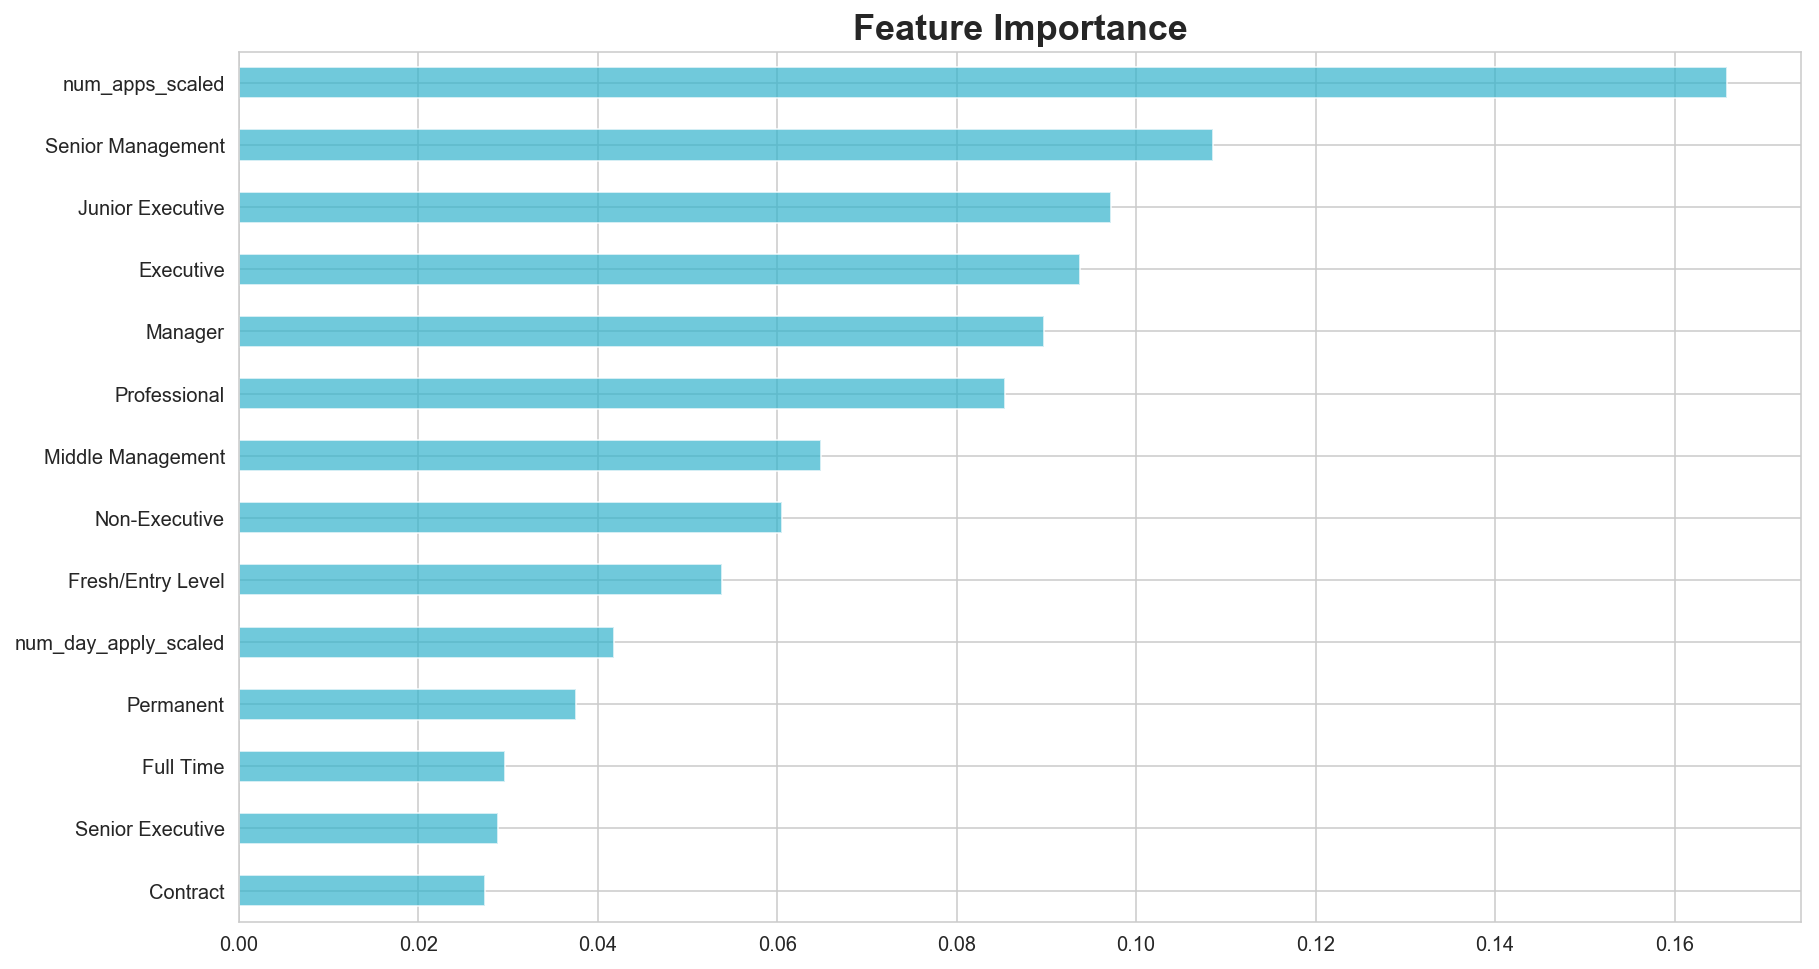

In [250]:
## Plot for feature importance #

rfc=gs_rf.best_estimator_
rfc.fit(Xd_train,y_train)
rfr_feats=pd.DataFrame({'variable':Xd_train.columns,
 'feature_importance':rfc.feature_importances_})

rfr_feats.sort_values(by='feature_importance',inplace=True)
f=plt.figure(figsize=(14,8))

# Look at features which have importance above >0.01 # 
ax=rfr_feats['feature_importance'][rfr_feats['feature_importance']>0.01].plot.barh(color=(0.2,0.7,0.8),alpha=0.7)
ax.set_yticklabels(rfr_feats['variable'][rfr_feats['feature_importance']>0.01])
ax.set_title('Feature Importance',fontsize=18,fontweight='bold')
plt.show()


### Observations 

Unsuprisingly, the seniority features are highly important in determining salary level, with 'Senior Management' having the highest feature importance value. The number of applications per job listing, which indicates how competitive a job is, is also highly important. However, as we've used random forest for the model, we're unable to tell the direction of this influence. 

It could be possible that more competitive jobs have lower barriers-to-entry and hence a lower salary level, or more competitive jobs are more desirable and command a higher premium.

<h2><a name='stack'> 3.3 L2 Model : Stacking 3 L1 models</a></h2>

Having evaluated 3 Level 1 models, I will stack all three models to generate a meta-feature set for the Level 2 models. For the L2 Model, I will consider 4 "Super Learners", namely Random Forest, SVM, Logistic Regression and XGBoost.


In [404]:
# Set up a list of Level 1 models for stacking # 

models_L1=[{'model':NLP_JD.best_estimator,
            'name':'TF-IDF + Logistic Regression using JD as features',
            'X_train':salary_train['job_description'],
            'X_test':salary_test['job_description'],
            'auc':roc_auc_score(y_test,NLP_JD.best_estimator.predict_proba(salary_test['job_description'])[:,1])
           },
          {'model':NLP_JR.best_estimator,
           'name':'TF-IDF + Logistic Regression using JR as features',
            'X_train':salary_train['job_requirements'],
            'X_test':salary_test['job_requirements'],
           'auc':roc_auc_score(y_test,NLP_JR.best_estimator.predict_proba(salary_test['job_requirements'])[:,1])
           },
            {'model':gs_rf.best_estimator_,
             'name':'Random Forest with numerical + categorical as features',
            'X_train':Xd_train,
            'X_test':Xd_test,
            'auc':roc_auc_score(y_test,gs_rf.best_estimator_.predict_proba(Xd_test)[:,1])
           }
          ]

# Check AUC for the models # 
for model in models_L1:
    print('------------------------------------\n')
    print('AUC on test set for {}:{:2.2f}'.format(model['name'],model['auc']))
    print('\n')

------------------------------------

AUC on test set for TF-IDF + Logistic Regression using JD as features:0.87


------------------------------------

AUC on test set for TF-IDF + Logistic Regression using JR as features:0.84


------------------------------------

AUC on test set for Random Forest with numerical + categorical as features:0.78




Given the highest AUC for the Level 1 Models on the test set is 0.87, we'll have to try and improve on that with the next level of stacking.

In [406]:
def stacking(model,X_train,X_test,y_train,n_folds):
    ''' Takes the base model, training/test feature set and the target train set and generates a meta-feature training/test
    set for the level 2 model.'''
    
    # Generate indices for folds # 
    folds=StratifiedKFold(n_splits=n_folds,random_state=2019)
    # Initialise an empty list for out of fold predictions #
    train_pred=[]
    # Generate out of fold predictions # 
    for train_indices,val_indices in folds.split(X_train,y_train):
        
        x_t,x_v=X_train.iloc[train_indices],X_train.iloc[val_indices]
        y_t,y_v=y_train[train_indices],y_train[val_indices]
        
        model.fit(X=x_t,y=y_t)
        # Meta features are generated using the predicted class probabilities # 
        train_pred += model.predict_proba(x_v)[:,1].tolist()
    
    # Use whole training set to generate meta-feature test set # 
    model.fit(X=X_train,y=y_train)
    test_pred=model.predict_proba(X_test)[:,1]
    return test_pred,np.array(train_pred).reshape(-1,)

def gen_L2_features(models,y_train,n_folds=10):
    '''Generate the meta feature set given a list of L1 models'''
    train={}
    test={}
    
    for i,model in enumerate(models):
        # Generate column label for each model # 
        model_ind='model_'+str(i+1)
        # Generate meta-feature set for each model # 
        model_test,model_vals=stacking(model['model'],model['X_train'],model['X_test'],y_train,n_folds)
        train[model_ind]=model_vals
        test[model_ind]=model_test
    return pd.DataFrame(train),pd.DataFrame(test)

In [407]:
XL2_train,XL2_test=gen_L2_features(models_L1,y_train,n_folds=10)

In [408]:
XL2_train.sample(5)

,model_1,model_2,model_3
3026,0.030026,0.047919,0.139903
2571,0.409902,0.698531,0.559682
2773,0.119504,0.158574,0.570423
2138,0.594549,0.703156,0.791003
328,0.092219,0.238361,0.032576


In [409]:
XL2_train.shape

(3119, 3)

Here, I've generated a meta feature set with 3 columns and equal number of rows to the original training set using the predicted class probabilities for high salary as the meta-features. Next, I'll be training the super-learners and gridsearching for the best model hyper-parameters for each super-learner.

In [410]:
# Grid Search superlearner 1, xgboost # 
xgb_l2=XGBClassifier()
params={
    'learning_rate':np.linspace(0.3,0.1,num=5),
    'max_depth':[6,7,8,9],
    'gamma':np.linspace(0.1,0.5,num=5),
    'min_child_weight':[1,3,5],
}
xgb_gs2=GridSearchCV(xgb_l2,param_grid=params,cv=5,scoring='roc_auc')
xgb_gs2.fit(XL2_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': array([0.3 , 0.25, 0.2 , 0.15, 0.1 ]), 'max_depth': [6, 7, 8, 9], 'gamma': array([0.1, 0.2, 0.3, 0.4, 0.5]), 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [411]:
xgb2=xgb_gs2.best_estimator_
xgb2.fit(XL2_test,y_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.30000000000000004, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=5, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [412]:
# Super learner 2 : Random Forest # 
rf_clf2=RandomForestClassifier()

rfr_params={
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'n_estimators': [50,100,150,200]}

gs_rf2=GridSearchCV(rf_clf2,rfr_params,scoring='roc_auc')
gs_rf2.fit(XL2_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'n_estimators': [50, 100, 150, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [413]:
rfc2=gs_rf2.best_estimator_
rfc2.fit(XL2_test,y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [414]:
# Super Learner 3, Logistic Regression # 
lrcv=LogisticRegressionCV(cv=5,scoring='roc_auc')
lrcv.fit(XL2_train,y_train)
lr2=LogisticRegression(C=lrcv.C_[0])
lr2.fit(XL2_test,y_test)

LogisticRegression(C=0.046415888336127774, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [476]:
# Super Learner 4, Support Vector Classifier # 
svc=SVC(probability=True)
svc_params={
    'C':[0.001, 0.01, 0.1, 1, 10],
    'gamma':[0.001, 0.01, 0.1, 1],
    'kernel':['linear','rbf']}

svc_gs=GridSearchCV(svc,svc_params,scoring='roc_auc',cv=5)
svc_gs.fit(XL2_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['linear', 'rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [479]:
svc2=svc_gs.best_estimator_
svc2.fit(XL2_test,y_test)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [482]:
# Set up a list of super learner candidates # 

models_L2=[{'model':xgb2,
            'name':'XGBoost',
            'auc':roc_auc_score(y_test,xgb2.predict_proba(XL2_test)[:,1]),
           },
          {'model':rfc2,
           'name':'Random Forest',
           'auc':roc_auc_score(y_test,rfc2.predict_proba(XL2_test)[:,1])
           },
            {'model':lr2,
             'name':'Logistic Regreesion',
            'auc':roc_auc_score(y_test,lr2.predict_proba(XL2_test)[:,1])
           },
            {'model':svc2,
             'name':'Linear SVC',
            'auc':roc_auc_score(y_test,svc2.predict_proba(XL2_test)[:,1])
           }
          ]
# Compare results for the super learners # 
print('Level 2 Model Selection')
for model in models_L2:
    print('------------------------------------\n')
    print('AUC on test set for {}: {:2.10f}'.format(model['name'],model['auc']))

Level 2 Model Selection
------------------------------------

AUC on test set for XGBoost: 0.9683133126
------------------------------------

AUC on test set for Random Forest: 0.9996626154
------------------------------------

AUC on test set for Logistic Regreesion: 0.8948223239
------------------------------------

AUC on test set for Linear SVC: 0.8955755545


Stacking improved on our baseline models tremendously with the best super-learner being Random Forest with AUC of 0.9997. 

This model 


In [419]:
from sklearn.metrics import roc_curve, auc

In [472]:
y_score1=svc2.predict_proba(XL2_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test,y_score1)
roc_auc=auc(fpr,tpr)
y_score2= xgb2.predict_proba(XL2_test)[:,1]
fpr2,tpr2, thres2= roc_curve(y_test,y_score2)
roc_auc2=auc(fpr2,tpr2)

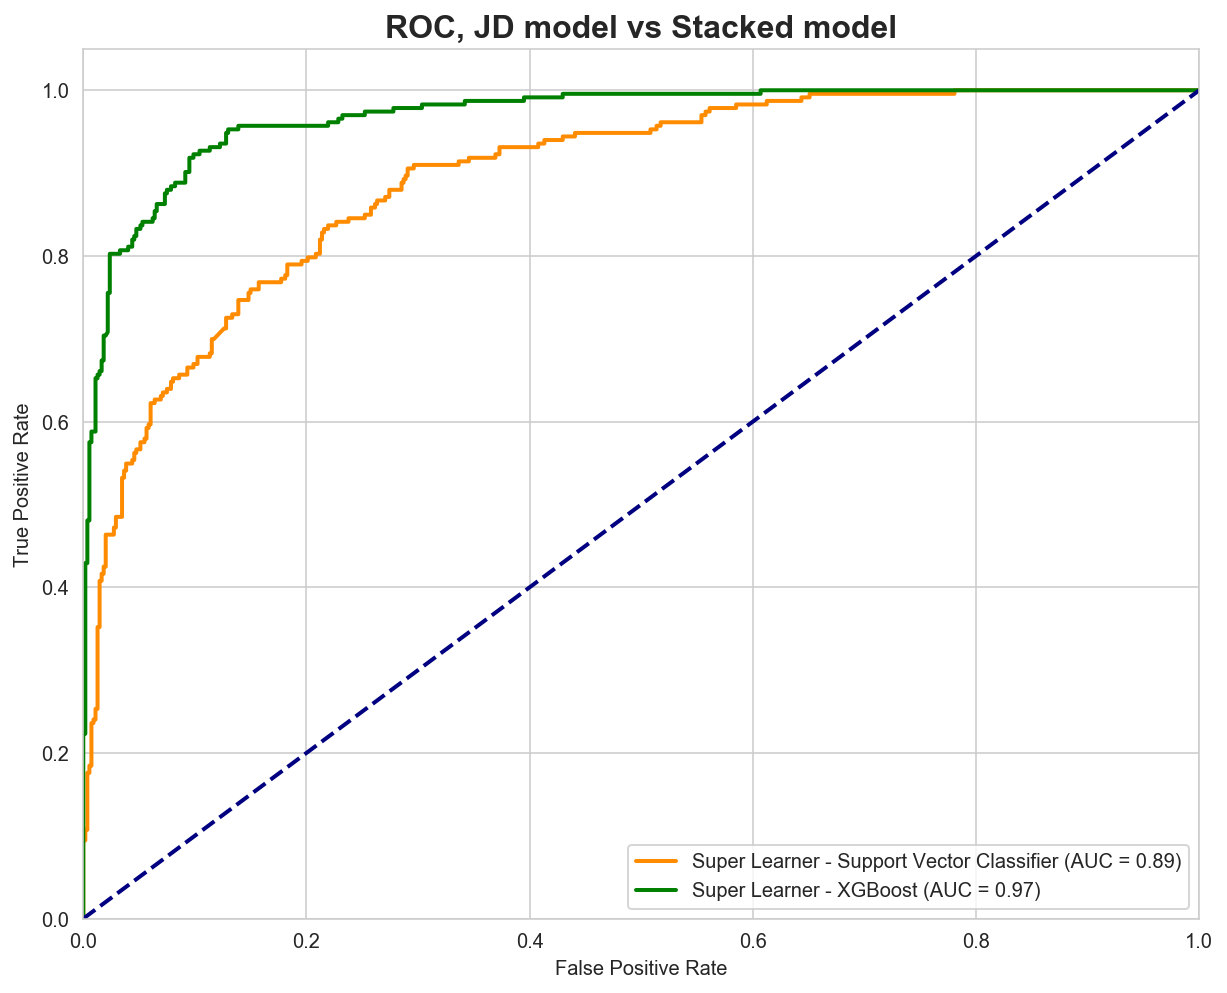

In [474]:
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Super Learner - Support Vector Classifier (AUC = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2, color='green',
         lw=lw, label='Super Learner - XGBoost (AUC = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC, JD model vs Stacked model',fontsize=16,fontweight='bold')
plt.legend(loc="lower right")
plt.show()

In [ ]:
SVC()

<h2><a name='feature'>4. Job Category Analysis </a></h2>

In this part of the analysis, I'll be looking at non-salary characteristics about a job-listing. There will be two main questions I'll be trying to answer: 

- **What skills set apart a data expert vs a data-related job?** I'll be focusing on three main types of jobs that require deeper data skills, ie. Data Scientist, Data Analyst, Business Analyst.    
<br>
- **What skills set apart senior roles from the rest**?



<h2><a name='skills'> 4.1 What skills are required for a data gig? </a></h2>

It might be pointing out the obvious to say that analytic, programming and statistical skills are required to score a data job, but are 

In [454]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4416 entries, 0 to 418
Data columns (total 13 columns):
company_location    3379 non-null object
company_name        4416 non-null object
date_expiry         4416 non-null object
date_posted         4416 non-null object
employment_type     4416 non-null object
job_description     4416 non-null object
job_requirements    4233 non-null object
job_title           4416 non-null object
num_apps            4416 non-null float64
salary_lower        3912 non-null float64
salary_type         3912 non-null object
salary_upper        3912 non-null float64
seniority           4334 non-null object
dtypes: float64(3), object(10)
memory usage: 483.0+ KB


In [455]:
skills=df[df['job_requirements'].notna()]


In [462]:
jt_stopwords=['sr','senior','jr','junior','associate','and']
skills['job_title_']=skills['job_title'].apply(lambda x: re.sub('[^ \w*\d\w*]','',x.lower()))

In [463]:
vec=CountVectorizer(stop_words=jt_stopwords,min_df=2)
X=vec.fit_transform(skills['job_title_'])
plt.figure(figsize=(16,8))
f=pd.DataFrame(X.todense(),columns=vec.get_feature_names()).apply(sum).sort_values(ascending=False).head(30).plot.bar()

label1=f.get_xticklabels()
f.set_xticklabels(label1,rotation=70)
f.set_title('Bag of Words', fontsize=14)
plt.show()

In [295]:
bow_df=pd.DataFrame(X.todense(),columns=vec.get_feature_names())


def job_cats(x):
    if (x.data !=0 and x.scientist !=0) or (x.data !=0 and x.analyst!=0) or (x.analyst!=0 and x.business!=0):
        return 'Data Expert'
    elif (x.engineer==1):
        return 'Engineer'
    else:
        return 'Others'
skills['job_type']=bow_df.apply(lambda x: job_cats(x),axis=1)


In [449]:
skills=skills[skills['job_type']!='Engineer'].reset_index(drop=True)

In [451]:
skills['job_type'].value_counts()

Others         2995
Data Expert     451
Name: job_type, dtype: int64

In [452]:
skills['job_requirements']

0       RequirementsMinimum qualifications: - Bachelor...
1       RequirementsRequirements:     A bachelor’s deg...
2       RequirementsMinimum Required Skills and Knowle...
3       RequirementsRequirements:  Minimum Bachelor’s ...
4       Requirements Minimum Diploma/ Degree in Statis...
5       Requirements Masters or equivalent degree in S...
6       RequirementsWHAT WE VALUE  BA/BS (or MA/MS) or...
7       RequirementsQualifications:  Deep expertise in...
8       Requirements Degree in banking and finance or ...
9       Requirements Degree in Information Technology ...
10      Requirements PhD/Masters/Bachelors (with good ...
11      Requirements PhD/Masters/Bachelors (with good ...
12      Requirements At least two years relevant worki...
13      Requirements  Degree holder, with at least 4 -...
14      Requirements Good knowledge in Operations Rese...
15      RequirementsThis role is a position within the...
16      RequirementsRequirements: BA/BS degree in scie...
17      Requir